# Simulation for PHASE 1

We'll build the environment, agent states, fitness landscape, and learning rules...

### Step 1: Setting Up the Environment (The Knowledge Map)

First, define your "world" - the branching Knowledge Map.

In [1]:
import numpy as np
from scipy import stats # For calculating the modal state later
import matplotlib.pyplot as plt

# --- 1. Define the Knowledge Map ---
# Keys are node IDs (integers). Values are dictionaries with properties.
# 'fitness': Survival probability V(Kj)
# 'branch': Identifier ('start', 'low_risk', 'high_risk') [cite: 8, 44]
# 'next_node': ID of the *next* node on the *same* branch for incremental IL
#              Use None or the node itself if it's a plateau/end point.

knowledge_map = {
    # Starting Node
    0: {'fitness': 0.86, 'branch': 'start', 'next_node': 1}, # Connects primarily to low-risk

    # Low-Risk Branch (Fast gains, local optimum V_max_low = 0.92) [cite: 8, 44, 909]
    1: {'fitness': 0.88, 'branch': 'low_risk', 'next_node': 2},
    2: {'fitness': 0.90, 'branch': 'low_risk', 'next_node': 3},
    3: {'fitness': 0.91, 'branch': 'low_risk', 'next_node': 4},
    4: {'fitness': 0.92, 'branch': 'low_risk', 'next_node': 4}, # Local plateau

    # High-Risk Branch (Slower initial gains, global optimum V_max_high = 0.95) [cite: 8, 44, 915]
    # This branch needs to be "discovered" via Exploratory IL [cite: 26, 47, 816]
    10: {'fitness': 0.85, 'branch': 'high_risk', 'next_node': 11}, # Initial fitness dip
    11: {'fitness': 0.87, 'branch': 'high_risk', 'next_node': 12},
    12: {'fitness': 0.89, 'branch': 'high_risk', 'next_node': 13},
    13: {'fitness': 0.93, 'branch': 'high_risk', 'next_node': 14},
    14: {'fitness': 0.95, 'branch': 'high_risk', 'next_node': 14}  # Global plateau
}

# --- Define Constants ---
START_NODE = 0
HIGH_RISK_START_NODE = 10 # Node discovered by Exploratory IL [cite: 27, 47, 816]
N_NODES = len(knowledge_map) # Total number of nodes

**Explanation:**

Created the two branches as described in our proposal.

The fitness values represent $V(K_j). Notice the Low-Risk branch rises faster but peaks lower than the High-Risk branch.

next_node simplifies Incremental IL - it tells an agent where to go next on their current path.

### Step 2: Initializing the Agent Population

Next, create a function to set up our agents. This replaces the old create_population function. Agents will now have a state representing their node on the map.

In [2]:
# --- 2. Create Agent Population ---
def initialize_population(N, phi=0.5, initial_node=START_NODE):
    """Initializes the population of N agents."""
    # State Vector Kj(t): Each agent's current node ID
    agent_states = np.full(N, initial_node, dtype=np.int64)

    # Agent properties (can add more later if needed)
    is_social_learner = np.random.rand(N) < phi # Probability phi of being a social learner type
    ai_bias = np.random.rand(N) # Example: Random bias initially

    # Keep track of age for potential future analysis
    age = np.ones(N, dtype=np.int64)

    # For Status-Biased SL [cite: 49, 818] (optional for initial setup)
    # Track survival streak or similar metric if needed later

    # Track discovered nodes globally for RD metric
    discovered_nodes = {initial_node} # Start with the initial node discovered

    return agent_states, is_social_learner, ai_bias, age, discovered_nodes

**Explanation:**

agent_states: This is your $K_j(t)$ vector, storing the current node ID for each agent. Everyone starts at START_NODE.

discovered_nodes: A set to efficiently track unique nodes visited by any agent, needed for the $R_D$ metric.

### Step 3: Building the Core Simulation Loop

This is the main function that runs the simulation generation by generation. We'll adapt the structure from the baseline code but use our new map and states.

In [14]:
# --- 3. Core Simulation Function ---
def run_simulation_knowledge_map(
    knowledge_map_dict, # Pass the map definition
    N=1000,
    n_generations=50000, # Shorter for initial testing, increase later
    u=0.01, # Environmental change prob
    c_I=0.05, # Cost of IL
    z_I=0.66, # Success rate of IL
    c_S=0.0, # Cost of SL
    # s0, s1 are replaced by V(Kj) from the map
    phi=0.5, # Initial proportion of social learners
    mu=0.005, # Mutation rate
    exploration_prob=0.01, # Prob of Exploratory IL
    alpha=1.0, # Strength of Status-Biased SL (set > 0 to enable)
    ai_mode='modal', # AI learning rule: 'modal', 'mean', 'prestige', or 'none. Picking modal cuz The it represents the simplest case where the AI acts as a strong conformist social learner, reinforcing the most common strategy (often the easy Low-Risk path)
    ai_update_cadence=1, # How often AI updates (1 = every generation)
    critical_threshold=0.90, # Example threshold for Tc
    convergence_window=100, # Window for checking Tc stability
    convergence_epsilon=0.0001 # Threshold for Tc stability
    ):
    """Runs the simulation on the Knowledge Map."""

    agent_states, is_social_learner, ai_bias, age, discovered_nodes = initialize_population(N, phi)

    # --- Metrics Tracking ---
    history_Qm = [] # Mastery Score
    history_Rd = [] # Discovery Rate (new nodes per gen)
    history_Rd_high = [] # Discovery Rate for High-Risk branch
    history_pop_distribution = [] # Track % of pop on each branch

    Tc = -1 # Convergence time, -1 if not reached
    ai_state = START_NODE # Initial AI knowledge

    # --- Determine minlength for bincount ---
    max_node_id = max(knowledge_map_dict.keys())
    bincount_minlength = max_node_id + 1


    # === Generation Loop ===
    for gen in range(n_generations):

        # --- Environmental Change (Optional Reset) ---
        if np.random.rand() < u:
            # Reset agent states and discoveries (simplest form)
            agent_states.fill(START_NODE)
            discovered_nodes = {START_NODE}
            # Could implement more complex resets later if needed

        # --- Learning Phase ---
        new_agent_states = agent_states.copy() # Work on a copy
        new_discoveries_this_gen = 0
        new_discoveries_high_risk = 0

        for i in range(N):
            # --- Determine Learning Strategy (Individual vs Social) ---
            learn_social = is_social_learner[i] # Basic choice for now

            if learn_social:
                # --- Social Learning (SL or AI) ---
                if np.random.rand() > c_S: # Check cost

                    # --- Choose Teacher (Human vs AI) ---
                    # Simple bias for now, can refine later
                    teach_from_ai = (np.random.rand() < ai_bias[i]) and (ai_mode != 'none')

                    if teach_from_ai:
                        # --- AI Learning ---
                        new_state = ai_state
                        new_agent_states[i] = new_state
                        # NOTE: Deskilling is structural here - AI pulls to common state

                    else:
                        # --- Human Social Learning ---
                        # (a) Local SL: Filter peers (e.g., same branch)
                        my_node = agent_states[i]
                        my_branch = knowledge_map_dict[my_node]['branch']
                        peer_indices = np.where(
                            np.array([knowledge_map_dict[state]['branch'] == my_branch for state in agent_states])
                        )[0]
                        # Remove self from potential teachers
                        peer_indices = peer_indices[peer_indices != i]

                        if len(peer_indices) > 0:
                            # (b) Status-Biased SL
                            if alpha > 0:
                                peer_fitness = np.array([knowledge_map_dict[agent_states[p]]['fitness'] for p in peer_indices])
                                # Use fitness difference, power by alpha
                                weights = np.power(peer_fitness - np.min(peer_fitness) + 1e-6, alpha) # Add epsilon for stability
                                if np.sum(weights) > 0:
                                     weights /= np.sum(weights)
                                else: # If all weights are zero (e.g., all peers at same low fitness)
                                     weights = np.ones(len(peer_indices)) / len(peer_indices) # Uniform random choice
                            else: # Uniform random choice among local peers
                                weights = np.ones(len(peer_indices)) / len(peer_indices)

                            # Choose teacher and copy state
                            teacher_index = np.random.choice(peer_indices, p=weights)
                            new_state = agent_states[teacher_index]
                            new_agent_states[i] = new_state
                        else:
                            # No local peers? Default to IL (or stay put)
                            learn_social = False # Fallback to IL section

            # Note: We structure IL to happen if learn_social is False OR if SL failed (no local peers)
            if not learn_social:
                 # --- Individual Learning (IL) ---
                if np.random.rand() > c_I: # Check cost
                    if np.random.rand() < z_I: # Check success prob

                        # --- Exploratory vs Incremental ---
                        if np.random.rand() < exploration_prob:
                             # (Exploratory) Discover High-Risk
                            new_state = HIGH_RISK_START_NODE
                            new_agent_states[i] = new_state
                        else:
                            # (Incremental) Move along current branch
                            current_node = agent_states[i]
                            next_node = knowledge_map_dict[current_node]['next_node']
                            if next_node is not None: # Check if not at a plateau
                                new_state = next_node
                                new_agent_states[i] = new_state
                            else:
                                new_state = current_node # Stay at plateau
                    else: # IL failed intrinsically
                        new_state = agent_states[i] # Stay put
                else: # Failed cost check for IL
                     new_state = agent_states[i] # Stay put

            # --- Check for New Discovery (for RD metric) ---
            final_new_state = new_agent_states[i]
            if final_new_state not in discovered_nodes:
                new_discoveries_this_gen += 1
                discovered_nodes.add(final_new_state)
                if knowledge_map_dict[final_new_state]['branch'] == 'high_risk':
                    new_discoveries_high_risk += 1


        agent_states = new_agent_states # Update all agent states

        # --- Survival Phase ---
        # Get current fitness values for *all* agents
        agent_fitness_values = np.array([knowledge_map_dict[state]['fitness'] for state in agent_states])
        survival_roll = np.random.rand(N)
        survival_mask = survival_roll < agent_fitness_values

        # Store the fitness values *before* applying the mask for Qm calculation
        current_pop_fitness_values = agent_fitness_values

        agent_states = agent_states[survival_mask]
        is_social_learner = is_social_learner[survival_mask]
        ai_bias = ai_bias[survival_mask]
        age = age[survival_mask]
        age += 1 # Increment age of survivors

        # --- Reproduction Phase ---
        current_pop_size = len(agent_states)
        n_offspring = N - current_pop_size

        if n_offspring > 0:
            if current_pop_size == 0: # Handle extinction case
                 # Re-initialize population or end simulation
                 # For now, re-initialize
                 agent_states, is_social_learner, ai_bias, age, discovered_nodes = initialize_population(N, phi)
            else:
                # Select parents proportionally to fitness (or randomly from survivors)
                parent_indices = np.random.choice(current_pop_size, size=n_offspring, replace=True) # Random parents for simplicity

                # Inherit state and traits with mutation
                offspring_states = agent_states[parent_indices]
                offspring_social = is_social_learner[parent_indices]
                offspring_bias = ai_bias[parent_indices]

                # Mutation
                mutation_mask_social = np.random.rand(n_offspring) < mu
                offspring_social[mutation_mask_social] = ~offspring_social[mutation_mask_social]

                mutation_mask_bias = np.random.rand(n_offspring) < mu
                offspring_bias[mutation_mask_bias] += np.random.normal(0, 0.1, size=np.sum(mutation_mask_bias)) # Small bias mutation

                # Append offspring
                agent_states = np.concatenate((agent_states, offspring_states))
                is_social_learner = np.concatenate((is_social_learner, offspring_social))
                ai_bias = np.concatenate((ai_bias, offspring_bias))
                age = np.concatenate((age, np.ones(n_offspring, dtype=np.int64)))

        # --- AI Update Phase ---
        if ai_mode != 'none' and gen % ai_update_cadence == 0:
            if len(agent_states) > 0: # Ensure population is not extinct
                if ai_mode == 'modal':
                    mode_result = stats.mode(agent_states)
                    # Check if mode_result.mode is scalar or array; take the first element if array.
                    # In recent scipy versions, .mode is always an array.
                    ai_state = mode_result.mode[0] if isinstance(mode_result.mode, np.ndarray) else mode_result.mode
                    #ai_state = stats.mode(agent_states)[0][0]
                elif ai_mode == 'mean': # Find node closest to mean fitness
                     mean_pop_fitness = np.mean([knowledge_map_dict[s]['fitness'] for s in agent_states])
                     node_fitnesses = np.array([v['fitness'] for v in knowledge_map_dict.values()])
                     closest_node_idx = np.abs(node_fitnesses - mean_pop_fitness).argmin()
                     ai_state = list(knowledge_map_dict.keys())[closest_node_idx]
                elif ai_mode == 'prestige': # Find node of highest fitness agent
                     best_agent_idx = np.argmax([knowledge_map_dict[s]['fitness'] for s in agent_states])
                     ai_state = agent_states[best_agent_idx]
            else: # If population extinct, reset AI
                ai_state = START_NODE


        # --- Record Metrics for this Generation ---
        # Use fitness values from *before* survival selection for accurate Qm
        current_Qm = np.mean(current_pop_fitness_values) if N > 0 else 0
        history_Qm.append(current_Qm)
        history_Rd.append(new_discoveries_this_gen)
        history_Rd_high.append(new_discoveries_high_risk)

        # Calculate population distribution (optional but useful)
        # Ensure counts array is large enough for max node ID
        counts = np.bincount(agent_states, minlength=bincount_minlength)

        # Filter indices based on actual keys in knowledge_map_dict before summing
        start_nodes = [n for n, props in knowledge_map_dict.items() if props['branch'] == 'start']
        low_risk_nodes = [n for n, props in knowledge_map_dict.items() if props['branch'] == 'low_risk']
        high_risk_nodes = [n for n, props in knowledge_map_dict.items() if props['branch'] == 'high_risk']

        dist = {
            'start': np.sum(counts[start_nodes]) if start_nodes else 0,
            'low_risk': np.sum(counts[low_risk_nodes]) if low_risk_nodes else 0,
            'high_risk': np.sum(counts[high_risk_nodes]) if high_risk_nodes else 0,
        }
        history_pop_distribution.append({k: v/N for k, v in dist.items()})


        # --- Check for Convergence (Tc) ---
        if Tc == -1:
            # Option 1: Threshold based
            if current_Qm >= critical_threshold:
                 Tc = gen + 1
            # Option 2: Stability based (more robust)
            # if gen >= convergence_window:
            #     if np.abs(current_Qm - np.mean(history_Qm[-convergence_window:])) < convergence_epsilon:
            #         Tc = gen + 1


    # === End of Simulation ===
    return {
        'Qm': history_Qm,
        'Rd': history_Rd,
        'Rd_high': history_Rd_high,
        'Tc': Tc,
        'pop_dist': history_pop_distribution,
        'params': { # Keep track of parameters used
             'N':N, 'n_generations':n_generations, 'u':u, 'c_I':c_I, 'z_I':z_I, 'c_S':c_S,
             'phi':phi, 'mu':mu, 'exploration_prob':exploration_prob, 'alpha':alpha, 'ai_mode':ai_mode,
             'ai_update_cadence':ai_update_cadence,
             'critical_threshold': critical_threshold
        }
    }

**Explanation:**

This function orchestrates the entire process: environmental shifts, agent learning (IL, SL, AI based on rules), survival based on map fitness, reproduction with inheritance/mutation, and AI updates.

It explicitly includes our refined IL (Exploratory vs. Incremental) and SL (Local & Status-Biased).

It calculates and stores the $Q_M$, $R_D$, and $T_c$ metrics as defined.

The AI update logic now calculates the modal state. We also added placeholders for 'mean' and 'prestige' AI rules for your later experiments.

**Important:** It's a complex function. I am starting simple (e.g., only IL) and adding complexity (SL, AI) gradually by testing at each stage.

### Step 4: Running Experiments and Plotting Results

Set up code to run simulations with different parameters (with AI vs. without AI) and visualize the results.

Running Simulation WITHOUT AI...


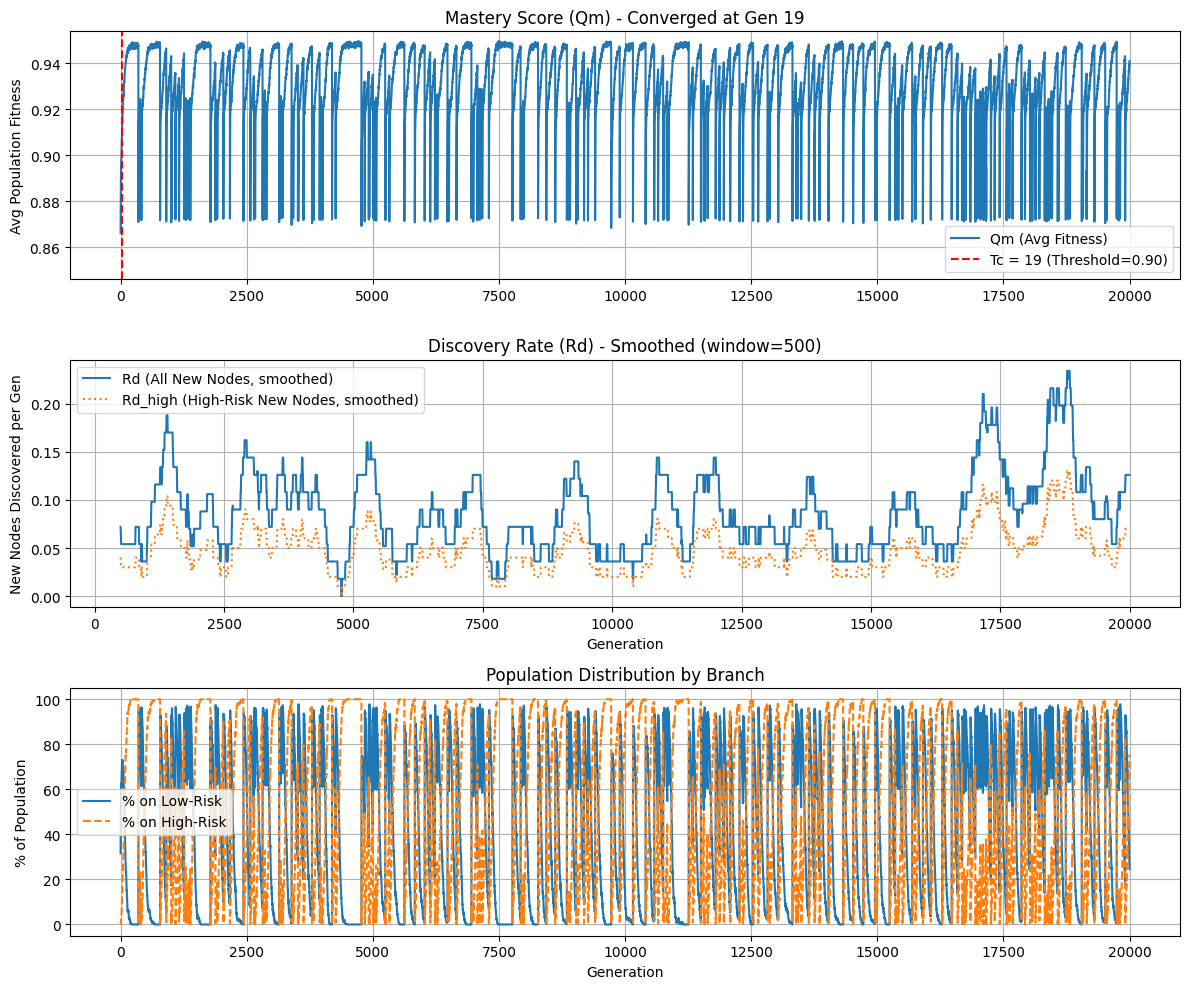


Running Simulation WITH Modal AI...


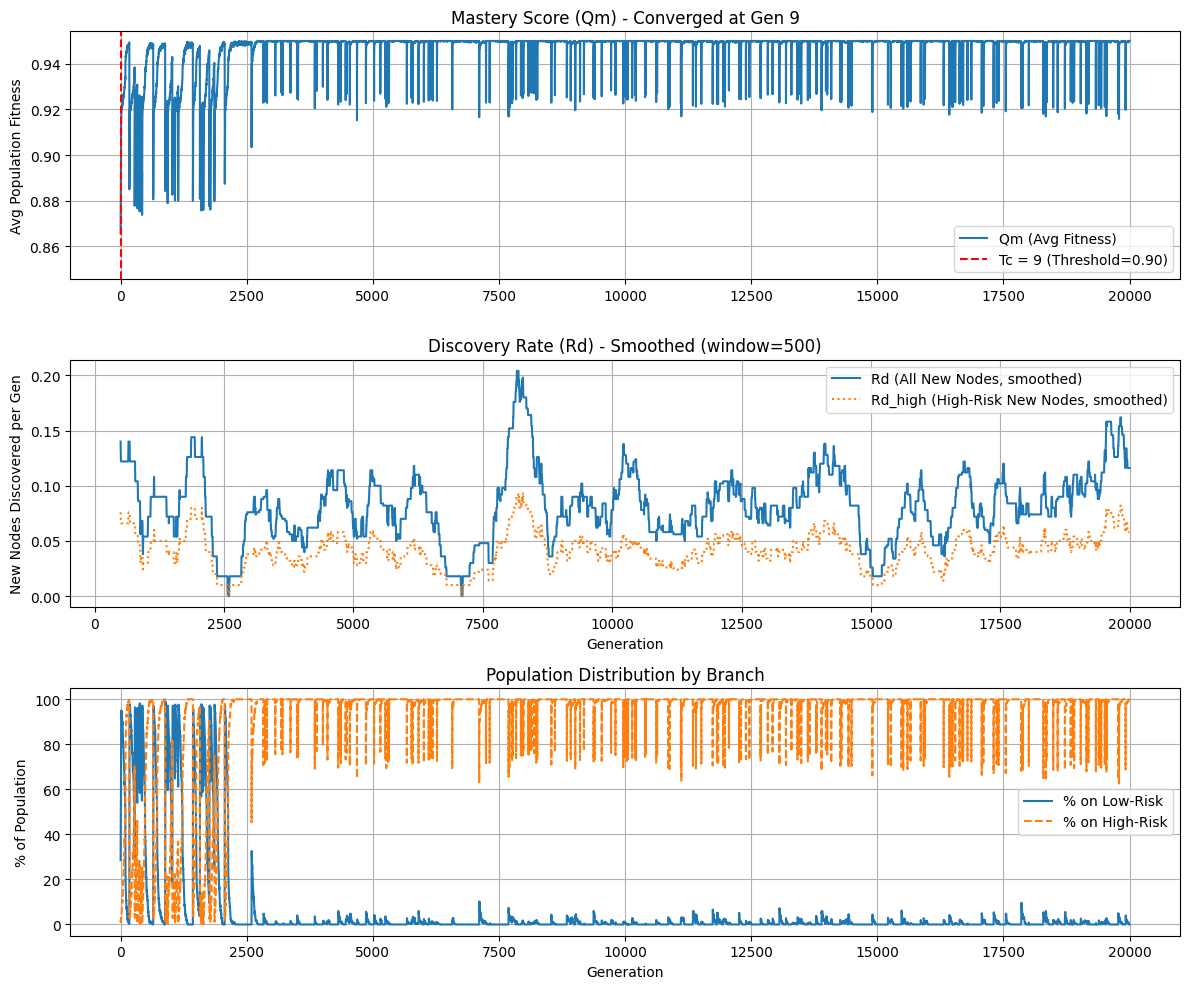

In [13]:
# --- 4. Experiment Runner and Plotting ---

def plot_simulation_results(results):
    """Plots the key metrics from a simulation run."""
    gens = range(results['params']['n_generations'])
    Qm = results['Qm']
    Rd = results['Rd']
    Rd_high = results['Rd_high']
    Tc = results['Tc']
    pop_dist = results['pop_dist']

    plt.figure(figsize=(12, 10))

    # Plot Mastery Score (Qm)
    plt.subplot(3, 1, 1)
    plt.plot(gens, Qm, label=f'Qm (Avg Fitness)')
    if Tc != -1:
        # (access threshold from results)
        threshold_val = results['params'].get('critical_threshold', 0.90) # Get from params, default if missing
        plt.axvline(Tc, color='r', linestyle='--', label=f'Tc = {Tc} (Threshold={threshold_val:.2f})')
        plt.title(f"Mastery Score (Qm) - Converged at Gen {Tc}")
    else:
        plt.title("Mastery Score (Qm) - Did Not Converge")
    plt.ylabel("Avg Population Fitness")
    plt.ylim(bottom=min(Qm)-0.02 if Qm else 0.8) # Adjust ylim for better view
    plt.legend()
    plt.grid(True)


    # Plot Discovery Rate (Rd)
    plt.subplot(3, 1, 2)
    # Use a rolling average for smoother Rd plot
    window = 500
    Rd_smooth = np.convolve(Rd, np.ones(window)/window, mode='valid')
    Rd_high_smooth = np.convolve(Rd_high, np.ones(window)/window, mode='valid')
    plt.plot(gens[window-1:], Rd_smooth, label='Rd (All New Nodes, smoothed)')
    plt.plot(gens[window-1:], Rd_high_smooth, label='Rd_high (High-Risk New Nodes, smoothed)', linestyle=':')
    plt.title(f"Discovery Rate (Rd) - Smoothed (window={window})")
    plt.ylabel("New Nodes Discovered per Gen")
    plt.xlabel("Generation")
    plt.legend()
    plt.grid(True)

     # Plot Population Distribution
    plt.subplot(3, 1, 3)
    low_risk_pct = [d['low_risk'] * 100 for d in pop_dist]
    high_risk_pct = [d['high_risk'] * 100 for d in pop_dist]
    start_pct = [d['start'] * 100 for d in pop_dist]
    plt.plot(gens, low_risk_pct, label='% on Low-Risk')
    plt.plot(gens, high_risk_pct, label='% on High-Risk', linestyle='--')
    # plt.plot(gens, start_pct, label='% at Start', linestyle=':') # Optional
    plt.title("Population Distribution by Branch")
    plt.ylabel("% of Population")
    plt.xlabel("Generation")
    plt.legend()
    plt.grid(True)


    plt.tight_layout()
    plt.show()

# --- Run Example Simulations ---
print("Running Simulation WITHOUT AI...")
params_no_ai = {
    'knowledge_map_dict': knowledge_map,
    'N': 500, # Smaller N for faster testing
    'n_generations': 20000, # Shorter duration for testing
    'ai_mode': 'none', # Turn off AI
    'alpha': 1.0 # Enable Status-Biased SL
}
results_no_ai = run_simulation_knowledge_map(**params_no_ai)
plot_simulation_results(results_no_ai)


print("\nRunning Simulation WITH Modal AI...")
params_with_ai = {
    'knowledge_map_dict': knowledge_map,
    'N': 500,
    'n_generations': 20000,
    'ai_mode': 'modal', # Turn on Modal AI
    'alpha': 1.0
}
results_with_ai = run_simulation_knowledge_map(**params_with_ai)
plot_simulation_results(results_with_ai)

**Explanation:**

plot_simulation_results: A helper function to visualize $Q_M$, $R_D$, $T_c$, and the population distribution across branches. This helps us compare different experimental conditions.

Example Runs: The code sets up and runs two basic scenarios: one without the AI (baseline for innovation) and one with the modal AI active.

Analysis: By comparing the plots from these two runs, we can start to test our primary hypothesis: Does the AI increase $Q_M$ and decrease $T_c$ while suppressing $R_{D\_high\_risk}$?

### Analysis of Simulation Results

**Image 1: Simulation WITHOUT AI**


*   **Mastery Score ($Q_M$)** - Converges relatively slowly ($T_c = 19$).

      Shows significant and frequent oscillations after initial convergence. The average fitness repeatedly dips down towards ~0.88 before recovering towards the peak (around 0.95).

*   **Discovery Rate ($R_D$)** - The overall discovery rate ($R_D$) shows distinct peaks corresponding to the population recovering fitness after dips.

      The High-Risk discovery rate ($R_{D\_high}$) closely tracks the overall $R_D$, indicating that when the population does explore (often after a fitness drop), it frequently finds nodes on the High-Risk branch.

*   **Population Distribution** - The population oscillates dramatically between the Low-Risk and High-Risk branches.

      There are periods where the majority is on the High-Risk path, followed by collapses where the majority shifts back to the Low-Risk path.

**Image 2: Simulation WITH Modal AI**


*   **Mastery Score ($Q_M$)** - Converges very quickly ($T_c = 9$).

      After convergence, the average fitness is much more stable and stays consistently high (around 0.94-0.95), with far fewer and smaller dips compared to the "Without AI" case.

*   **Discovery Rate ($R_D$)** - The overall discovery rate is generally lower and flatter after the initial phase.

      The High-Risk discovery rate is substantially suppressed throughout the simulation. It remains low and relatively flat, indicating very little innovation is happening.

*   **Population Distribution** - After a very brief initial exploration phase, the population quickly and permanently settles on the Low-Risk branch (solid blue line stays near 100%). There is almost no exploration of the High-Risk branch after the first ~2000 generations.


***Conclusion***

1.   Without AI: The population naturally oscillates. When fitness drops (perhaps due to environmental change u making the current optimum obsolete, or just stochasticity), agents are forced to explore again. This exploration frequently leads them back to the High-Risk (globally optimal) branch, resulting in a higher average discovery rate for innovative nodes ($R_{D\_high}$), even though the overall fitness ($Q_M$) is less stable.

2.   With Modal AI: The AI rapidly guides the population to the Low-Risk (locally optimal) branch because it's initially easier and becomes the most common strategy quickly. The AI then keeps the population trapped there. It stabilizes the average fitness ($Q_M$) at a "good enough" level but does so by drastically suppressing exploration and preventing the discovery ($R_{D\_high}$) of the High-Risk branch.


**In essence:** The AI increases stability and speed of convergence ($T_c$) but achieves this by locking the population into a sub-optimal state and killing long-term innovation. This strongly aligns with your hypothesis about the trade-off between Mastery Speed (and stability) and Discovery Rate.


### Step 5: Parameter Tweaking (Sensitivity Analysis)

For tweaking, prioritizing parameters that most directly influence the exploration vs. exploitation dynamic.

In [15]:
# --- 1. Define the Knowledge Map ---
# Keys are node IDs (integers). Values are dictionaries with properties.
# 'fitness': Survival probability V(Kj)
# 'branch': Identifier ('start', 'low_risk', 'high_risk')
# 'next_node': ID of the *next* node on the *same* branch for incremental IL
#              Use None or the node itself if it's a plateau/end point.

knowledge_map = {
    # Starting Node
    0: {'fitness': 0.86, 'branch': 'start', 'next_node': 1}, # Connects primarily to low-risk

    # Low-Risk Branch (Fast gains, local optimum V_max_low = 0.92)
    1: {'fitness': 0.88, 'branch': 'low_risk', 'next_node': 2},
    2: {'fitness': 0.90, 'branch': 'low_risk', 'next_node': 3},
    3: {'fitness': 0.91, 'branch': 'low_risk', 'next_node': 4},
    4: {'fitness': 0.92, 'branch': 'low_risk', 'next_node': 4}, # Local plateau

    # High-Risk Branch (Slower initial gains, global optimum V_max_high = 0.95)
    # This branch needs to be "discovered" via Exploratory IL
    10: {'fitness': 0.85, 'branch': 'high_risk', 'next_node': 11}, # Initial fitness dip
    11: {'fitness': 0.87, 'branch': 'high_risk', 'next_node': 12},
    12: {'fitness': 0.89, 'branch': 'high_risk', 'next_node': 13},
    13: {'fitness': 0.93, 'branch': 'high_risk', 'next_node': 14},
    14: {'fitness': 0.95, 'branch': 'high_risk', 'next_node': 14}  # Global plateau
}

# --- Define Constants ---
START_NODE = 0
HIGH_RISK_START_NODE = 10 # Node discovered by Exploratory IL
N_NODES = len(knowledge_map) # Total number of nodes

# --- 2. Create Agent Population ---
def initialize_population(N, phi=0.5, initial_node=START_NODE):
    """Initializes the population of N agents."""
    # State Vector Kj(t): Each agent's current node ID
    agent_states = np.full(N, initial_node, dtype=np.int64)

    # Agent properties (can add more later if needed)
    is_social_learner = np.random.rand(N) < phi # Probability phi of being a social learner type
    ai_bias = np.random.rand(N) # Example: Random bias initially

    # Keep track of age for potential future analysis
    age = np.ones(N, dtype=np.int64)

    # Track discovered nodes globally for RD metric
    discovered_nodes = {initial_node} # Start with the initial node discovered

    return agent_states, is_social_learner, ai_bias, age, discovered_nodes

# --- 3. Core Simulation Function ---
def run_simulation_knowledge_map(
    knowledge_map_dict, # Pass the map definition
    N=1000,
    n_generations=50000, # Shorter for initial testing, increase later
    u=0.01, # Environmental change prob
    c_I=0.05, # Cost of IL
    z_I=0.66, # Success rate of IL
    c_S=0.0, # Cost of SL
    # s0, s1 are replaced by V(Kj) from the map
    phi=0.5, # Initial proportion of social learners
    mu=0.005, # Mutation rate
    exploration_prob=0.01, # Prob of Exploratory IL
    alpha=1.0, # Strength of Status-Biased SL (set > 0 to enable)
    ai_mode='modal', # AI learning rule: 'modal', 'mean', 'prestige', or 'none'
    ai_update_cadence=1, # How often AI updates (1 = every generation)
    critical_threshold=0.90, # Example threshold for Tc
    convergence_window=100, # Window for checking Tc stability
    convergence_epsilon=0.0001 # Threshold for Tc stability
    ):
    """Runs the simulation on the Knowledge Map."""

    agent_states, is_social_learner, ai_bias, age, discovered_nodes = initialize_population(N, phi)

    # --- Metrics Tracking ---
    history_Qm = [] # Mastery Score
    history_Rd = [] # Discovery Rate (new nodes per gen)
    history_Rd_high = [] # Discovery Rate for High-Risk branch
    history_pop_distribution = [] # Track % of pop on each branch

    Tc = -1 # Convergence time, -1 if not reached
    ai_state = START_NODE # Initial AI knowledge

    # --- Determine minlength for bincount (FIX 1)---
    max_node_id = max(knowledge_map_dict.keys())
    bincount_minlength = max_node_id + 1


    # === Generation Loop ===
    for gen in range(n_generations):

        # --- Environmental Change (Optional Reset) ---
        if np.random.rand() < u:
            # Reset agent states and discoveries (simplest form)
            agent_states.fill(START_NODE)
            discovered_nodes = {START_NODE}
            # Could implement more complex resets later if needed

        # --- Learning Phase ---
        new_agent_states = agent_states.copy() # Work on a copy
        new_discoveries_this_gen = 0
        new_discoveries_high_risk = 0

        for i in range(N):
            # --- Determine Learning Strategy (Individual vs Social) ---
            learn_social = is_social_learner[i] # Basic choice for now

            if learn_social:
                # --- Social Learning (SL or AI) ---
                if np.random.rand() > c_S: # Check cost

                    # --- Choose Teacher (Human vs AI) ---
                    # Simple bias for now, can refine later
                    teach_from_ai = (np.random.rand() < ai_bias[i]) and (ai_mode != 'none')

                    if teach_from_ai:
                        # --- AI Learning ---
                        new_state = ai_state
                        new_agent_states[i] = new_state
                        # NOTE: Deskilling is structural here - AI pulls to common state

                    else:
                        # --- Human Social Learning ---
                        # (a) Local SL: Filter peers (e.g., same branch)
                        my_node = agent_states[i]
                        my_branch = knowledge_map_dict[my_node]['branch']
                        # Make sure agent states are valid before checking branches
                        valid_states_mask = np.isin(agent_states, list(knowledge_map_dict.keys()))
                        valid_agent_states = agent_states[valid_states_mask]

                        peer_indices = np.where(
                           np.array([knowledge_map_dict.get(state, {}).get('branch') == my_branch for state in valid_agent_states])
                        )[0]

                        # Map back to original indices if needed, or adjust logic
                        # For simplicity, let's use global indices but filter valid ones first
                        potential_peer_indices = np.arange(N)[valid_states_mask]
                        valid_peer_indices_on_branch = potential_peer_indices[peer_indices]

                        # Remove self from potential teachers
                        valid_peer_indices_on_branch = valid_peer_indices_on_branch[valid_peer_indices_on_branch != i]

                        if len(valid_peer_indices_on_branch) > 0:
                            # (b) Status-Biased SL
                            if alpha > 0:
                                peer_fitness = np.array([knowledge_map_dict[agent_states[p]]['fitness'] for p in valid_peer_indices_on_branch])
                                # Use fitness difference, power by alpha
                                weights = np.power(peer_fitness - np.min(peer_fitness) + 1e-6, alpha) # Add epsilon for stability
                                if np.sum(weights) > 0:
                                     weights /= np.sum(weights)
                                else: # If all weights are zero (e.g., all peers at same low fitness)
                                     weights = np.ones(len(valid_peer_indices_on_branch)) / len(valid_peer_indices_on_branch) # Uniform random choice
                            else: # Uniform random choice among local peers
                                weights = np.ones(len(valid_peer_indices_on_branch)) / len(valid_peer_indices_on_branch)

                            # Choose teacher and copy state
                            teacher_index = np.random.choice(valid_peer_indices_on_branch, p=weights)
                            new_state = agent_states[teacher_index]
                            new_agent_states[i] = new_state
                        else:
                            # No local peers? Default to IL (or stay put)
                            learn_social = False # Fallback to IL section

            # Note: We structure IL to happen if learn_social is False OR if SL failed (no local peers)
            if not learn_social:
                 # --- Individual Learning (IL) ---
                if np.random.rand() > c_I: # Check cost
                    if np.random.rand() < z_I: # Check success prob

                        # --- Exploratory vs Incremental ---
                        if np.random.rand() < exploration_prob:
                             # (Exploratory) Discover High-Risk
                            new_state = HIGH_RISK_START_NODE
                            new_agent_states[i] = new_state
                        else:
                            # (Incremental) Move along current branch
                            current_node = agent_states[i]
                            # Check if current_node exists in map (it should, but safety check)
                            if current_node in knowledge_map_dict:
                                next_node = knowledge_map_dict[current_node]['next_node']
                                if next_node is not None: # Check if not at a plateau
                                    new_state = next_node
                                    new_agent_states[i] = new_state
                                else:
                                    new_state = current_node # Stay at plateau
                            else: # Should not happen if agent_states are valid
                                new_state = agent_states[i] # Stay put
                    else: # IL failed intrinsically
                        new_state = agent_states[i] # Stay put
                else: # Failed cost check for IL
                     new_state = agent_states[i] # Stay put

            # --- Check for New Discovery (for RD metric) ---
            final_new_state = new_agent_states[i]
            # Ensure the new state is actually in the defined map before checking branch
            if final_new_state in knowledge_map_dict and final_new_state not in discovered_nodes:
                new_discoveries_this_gen += 1
                discovered_nodes.add(final_new_state)
                if knowledge_map_dict[final_new_state]['branch'] == 'high_risk':
                    new_discoveries_high_risk += 1


        agent_states = new_agent_states # Update all agent states

        # --- Survival Phase ---
        # Get current fitness values for *all* agents, ensuring state exists in map
        agent_fitness_values = np.array([knowledge_map_dict.get(state, {'fitness': 0.0})['fitness'] for state in agent_states])
        survival_roll = np.random.rand(N)
        survival_mask = survival_roll < agent_fitness_values

        # Store the fitness values *before* applying the mask for Qm calculation
        current_pop_fitness_values = agent_fitness_values

        agent_states = agent_states[survival_mask]
        is_social_learner = is_social_learner[survival_mask]
        ai_bias = ai_bias[survival_mask]
        age = age[survival_mask]
        age += 1 # Increment age of survivors

        # --- Reproduction Phase ---
        current_pop_size = len(agent_states)
        n_offspring = N - current_pop_size

        if n_offspring > 0:
            if current_pop_size == 0: # Handle extinction case
                 agent_states, is_social_learner, ai_bias, age, discovered_nodes = initialize_population(N, phi)
            else:
                parent_indices = np.random.choice(current_pop_size, size=n_offspring, replace=True)

                offspring_states = agent_states[parent_indices]
                offspring_social = is_social_learner[parent_indices]
                offspring_bias = ai_bias[parent_indices]

                mutation_mask_social = np.random.rand(n_offspring) < mu
                offspring_social[mutation_mask_social] = ~offspring_social[mutation_mask_social]

                mutation_mask_bias = np.random.rand(n_offspring) < mu
                offspring_bias[mutation_mask_bias] += np.random.normal(0, 0.1, size=np.sum(mutation_mask_bias))

                agent_states = np.concatenate((agent_states, offspring_states))
                is_social_learner = np.concatenate((is_social_learner, offspring_social))
                ai_bias = np.concatenate((ai_bias, offspring_bias))
                age = np.concatenate((age, np.ones(n_offspring, dtype=np.int64)))

        # --- AI Update Phase ---
        if ai_mode != 'none' and gen % ai_update_cadence == 0:
            if len(agent_states) > 0:
                if ai_mode == 'modal':
                    # FIX 2: More robust mode extraction
                    mode_result = stats.mode(agent_states)
                    ai_state = mode_result.mode[0] if isinstance(mode_result.mode, np.ndarray) else mode_result.mode
                elif ai_mode == 'mean':
                     mean_pop_fitness = np.mean([knowledge_map_dict.get(s, {'fitness': 0.0})['fitness'] for s in agent_states])
                     node_fitnesses = np.array([v['fitness'] for v in knowledge_map_dict.values()])
                     closest_node_idx = np.abs(node_fitnesses - mean_pop_fitness).argmin()
                     ai_state = list(knowledge_map_dict.keys())[closest_node_idx]
                elif ai_mode == 'prestige':
                     fitness_vals = [knowledge_map_dict.get(s, {'fitness': 0.0})['fitness'] for s in agent_states]
                     if fitness_vals: # Check if list is not empty
                         best_agent_idx = np.argmax(fitness_vals)
                         ai_state = agent_states[best_agent_idx]
                     else: # Default if no agents have fitness (shouldn't happen if pop > 0)
                        ai_state = START_NODE

            else:
                ai_state = START_NODE


        # --- Record Metrics for this Generation ---
        current_Qm = np.mean(current_pop_fitness_values) if N > 0 else 0
        history_Qm.append(current_Qm)
        history_Rd.append(new_discoveries_this_gen)
        history_Rd_high.append(new_discoveries_high_risk)

        # Calculate population distribution
        # FIX 1: Ensure counts array is large enough
        counts = np.bincount(agent_states, minlength=bincount_minlength)

        start_nodes = [n for n, props in knowledge_map_dict.items() if props['branch'] == 'start']
        low_risk_nodes = [n for n, props in knowledge_map_dict.items() if props['branch'] == 'low_risk']
        high_risk_nodes = [n for n, props in knowledge_map_dict.items() if props['branch'] == 'high_risk']

        # Ensure indices are within bounds of counts array before summing
        start_nodes_valid = [n for n in start_nodes if n < len(counts)]
        low_risk_nodes_valid = [n for n in low_risk_nodes if n < len(counts)]
        high_risk_nodes_valid = [n for n in high_risk_nodes if n < len(counts)]


        dist = {
            'start': np.sum(counts[start_nodes_valid]) if start_nodes_valid else 0,
            'low_risk': np.sum(counts[low_risk_nodes_valid]) if low_risk_nodes_valid else 0,
            'high_risk': np.sum(counts[high_risk_nodes_valid]) if high_risk_nodes_valid else 0,
        }
        history_pop_distribution.append({k: v/N for k, v in dist.items()})


        # --- Check for Convergence (Tc) ---
        if Tc == -1:
            if current_Qm >= critical_threshold:
                 Tc = gen + 1


    # === End of Simulation ===
    return {
        'Qm': history_Qm,
        'Rd': history_Rd,
        'Rd_high': history_Rd_high,
        'Tc': Tc,
        'pop_dist': history_pop_distribution,
        'params': { # Keep track of parameters used
             'N':N, 'n_generations':n_generations, 'u':u, 'c_I':c_I, 'z_I':z_I, 'c_S':c_S,
             'phi':phi, 'mu':mu, 'exploration_prob':exploration_prob, 'alpha':alpha, 'ai_mode':ai_mode,
             'ai_update_cadence':ai_update_cadence,
             'critical_threshold': critical_threshold # FIX 3: Store threshold
        }
    }


# --- 4. Experiment Runner and Plotting ---

# FIX 4: Add scenario_label argument and update titles
def plot_simulation_results(results, scenario_label=""):
    """Plots the key metrics from a simulation run."""
    gens = range(results['params']['n_generations'])
    Qm = results['Qm']
    Rd = results['Rd']
    Rd_high = results['Rd_high']
    Tc = results['Tc']
    pop_dist = results['pop_dist']
    # FIX 4: Get threshold from results dictionary
    threshold_val = results['params'].get('critical_threshold', 0.90)

    plt.figure(figsize=(12, 10))

    # Plot Mastery Score (Qm)
    plt.subplot(3, 1, 1)
    plt.plot(gens, Qm, label=f'Qm (Avg Fitness)')
    if Tc != -1:
        plt.axvline(Tc, color='r', linestyle='--', label=f'Tc = {Tc} (Threshold={threshold_val:.2f})')
        # FIX 4: Update title
        plt.title(f"Mastery Score (Qm) {scenario_label}- Converged at Gen {Tc}")
    else:
        # FIX 4: Update title
        plt.title(f"Mastery Score (Qm) {scenario_label}- Did Not Converge")
    plt.ylabel("Avg Population Fitness")
    plt.ylim(bottom=min(Qm)-0.02 if Qm else 0.8)
    plt.legend()
    plt.grid(True)


    # Plot Discovery Rate (Rd)
    plt.subplot(3, 1, 2)
    window = 500
    # Ensure Rd and Rd_high have enough elements for convolution
    if len(Rd) >= window:
        Rd_smooth = np.convolve(Rd, np.ones(window)/window, mode='valid')
        Rd_high_smooth = np.convolve(Rd_high, np.ones(window)/window, mode='valid')
        plt.plot(gens[window-1:], Rd_smooth, label='Rd (All New Nodes, smoothed)')
        plt.plot(gens[window-1:], Rd_high_smooth, label='Rd_high (High-Risk New Nodes, smoothed)', linestyle=':')
    else: # Plot raw data if too short for smoothing
        plt.plot(gens, Rd, label='Rd (All New Nodes, raw)')
        plt.plot(gens, Rd_high, label='Rd_high (High-Risk New Nodes, raw)', linestyle=':')
    # FIX 4: Update title
    plt.title(f"Discovery Rate (Rd) {scenario_label}- Smoothed (window={window})")
    plt.ylabel("New Nodes Discovered per Gen")
    plt.xlabel("Generation")
    plt.legend()
    plt.grid(True)

     # Plot Population Distribution
    plt.subplot(3, 1, 3)
    # Check if pop_dist is not empty before processing
    if pop_dist:
        low_risk_pct = [d.get('low_risk', 0) * 100 for d in pop_dist]
        high_risk_pct = [d.get('high_risk', 0) * 100 for d in pop_dist]
        # start_pct = [d.get('start', 0) * 100 for d in pop_dist] # Optional
        plt.plot(gens, low_risk_pct, label='% on Low-Risk')
        plt.plot(gens, high_risk_pct, label='% on High-Risk', linestyle='--')
        # plt.plot(gens, start_pct, label='% at Start', linestyle=':') # Optional
    # FIX 4: Update title
    plt.title(f"Population Distribution by Branch {scenario_label}")
    plt.ylabel("% of Population")
    plt.xlabel("Generation")
    plt.legend()
    plt.grid(True)


    plt.tight_layout()
    plt.show()

# --- Run Parameter Tweaking Experiments ---

# Baseline (already run, assuming results_no_ai and results_with_ai exist)
# print("--- Baseline ---")
# plot_simulation_results(results_no_ai, scenario_label="Without AI (Baseline)")
# plot_simulation_results(results_with_ai, scenario_label="With Modal AI (Baseline)")

# Tweak 1: Lower exploration_prob
print("\n--- Tweaking: Lower exploration_prob (0.005) ---")
params_low_exp = {
    'knowledge_map_dict': knowledge_map, 'N': 500, 'n_generations': 20000,
    'exploration_prob': 0.005, 'alpha': 1.0
}
# Without AI
results_no_ai_low_exp = run_simulation_knowledge_map(**params_low_exp, ai_mode='none')
plot_simulation_results(results_no_ai_low_exp, scenario_label="Without AI (Low Exp)")
# With AI
results_with_ai_low_exp = run_simulation_knowledge_map(**params_low_exp, ai_mode='modal')
plot_simulation_results(results_with_ai_low_exp, scenario_label="With Modal AI (Low Exp)")


# Tweak 2: Higher exploration_prob
print("\n--- Tweaking: Higher exploration_prob (0.02) ---")
params_high_exp = {
    'knowledge_map_dict': knowledge_map, 'N': 500, 'n_generations': 20000,
    'exploration_prob': 0.02, 'alpha': 1.0
}
# Without AI
results_no_ai_high_exp = run_simulation_knowledge_map(**params_high_exp, ai_mode='none')
plot_simulation_results(results_no_ai_high_exp, scenario_label="Without AI (High Exp)")
# With AI
results_with_ai_high_exp = run_simulation_knowledge_map(**params_high_exp, ai_mode='modal')
plot_simulation_results(results_with_ai_high_exp, scenario_label="With Modal AI (High Exp)")

# Tweak 3: Higher c_I
print("\n--- Tweaking: Higher c_I (0.10) ---")
params_high_cI = {
    'knowledge_map_dict': knowledge_map, 'N': 500, 'n_generations': 20000,
    'c_I': 0.10, 'alpha': 1.0
}
# Without AI
results_no_ai_high_cI = run_simulation_knowledge_map(**params_high_cI, ai_mode='none')
plot_simulation_results(results_no_ai_high_cI, scenario_label="Without AI (High c_I)")
# With AI
results_with_ai_high_cI = run_simulation_knowledge_map(**params_high_cI, ai_mode='modal')
plot_simulation_results(results_with_ai_high_cI, scenario_label="With Modal AI (High c_I)")


--- Tweaking: Lower exploration_prob (0.005) ---


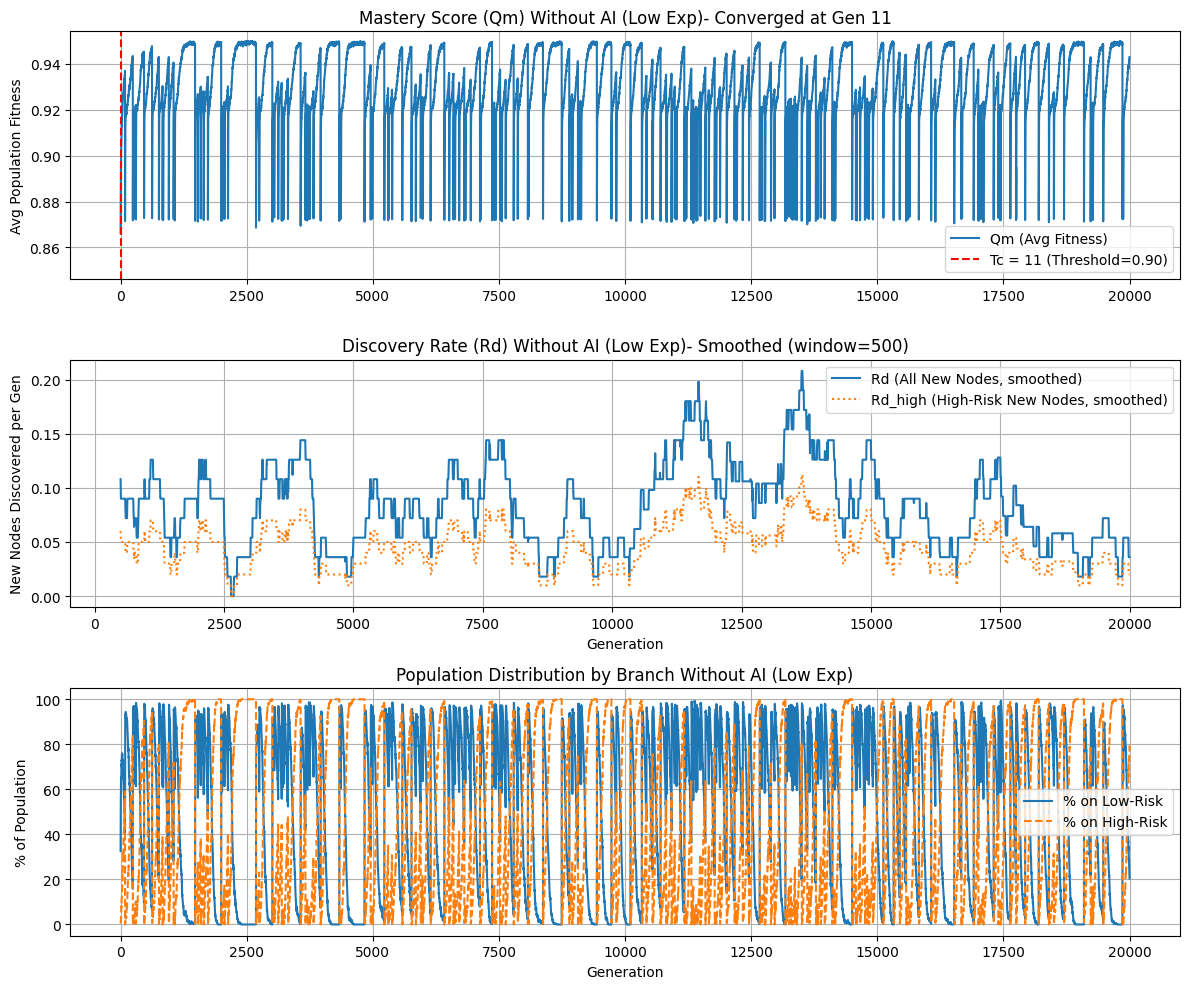

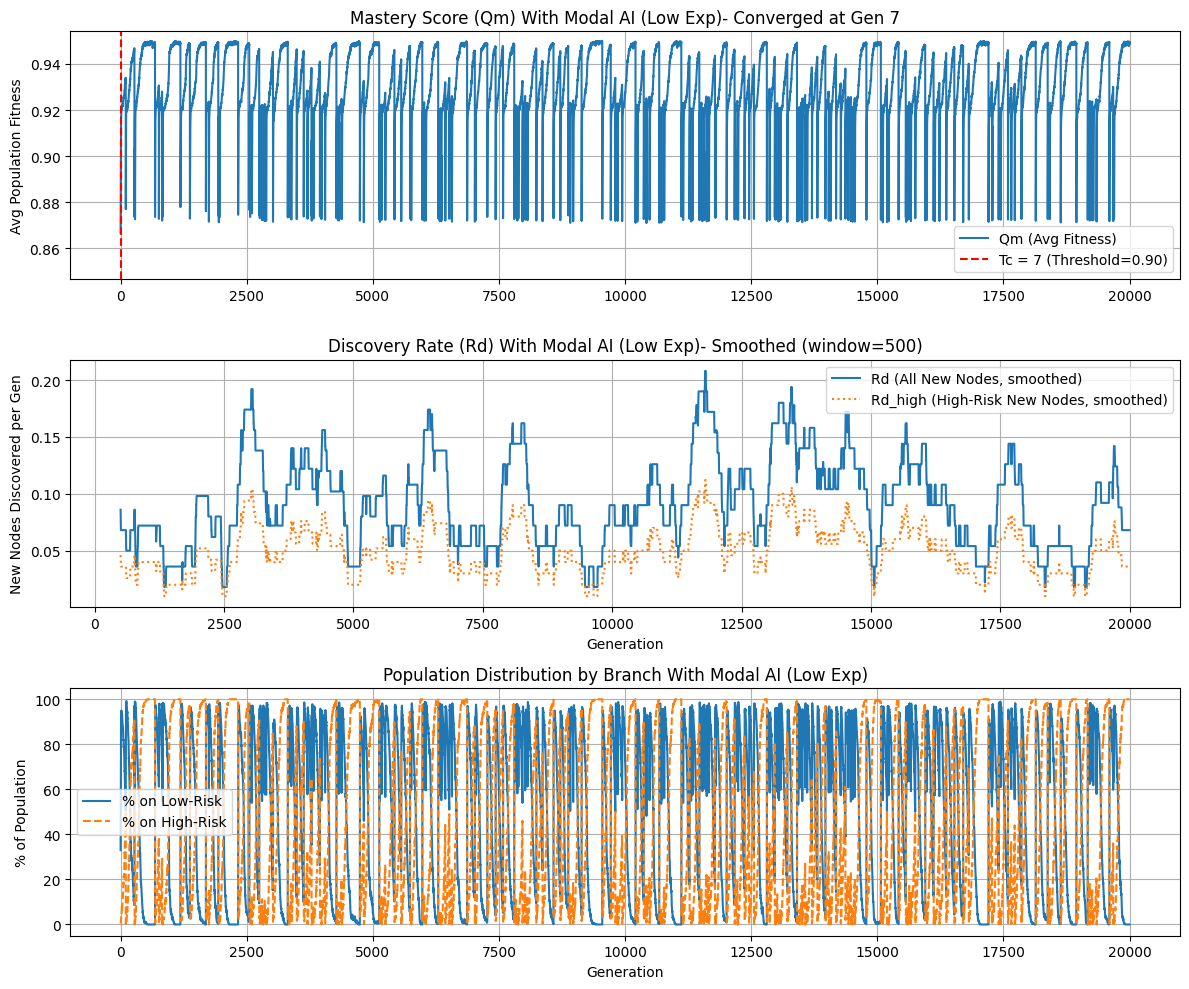


--- Tweaking: Higher exploration_prob (0.02) ---


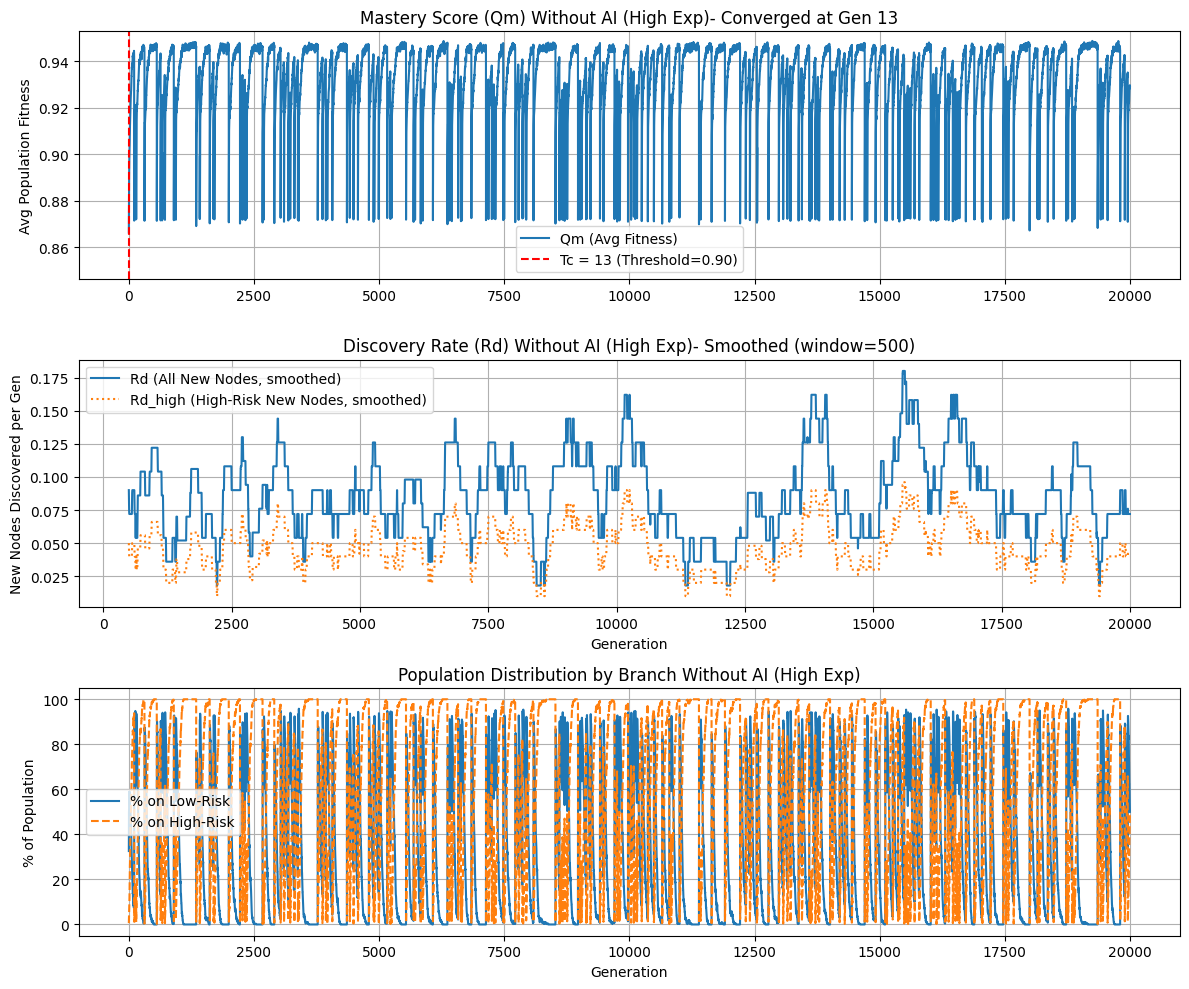

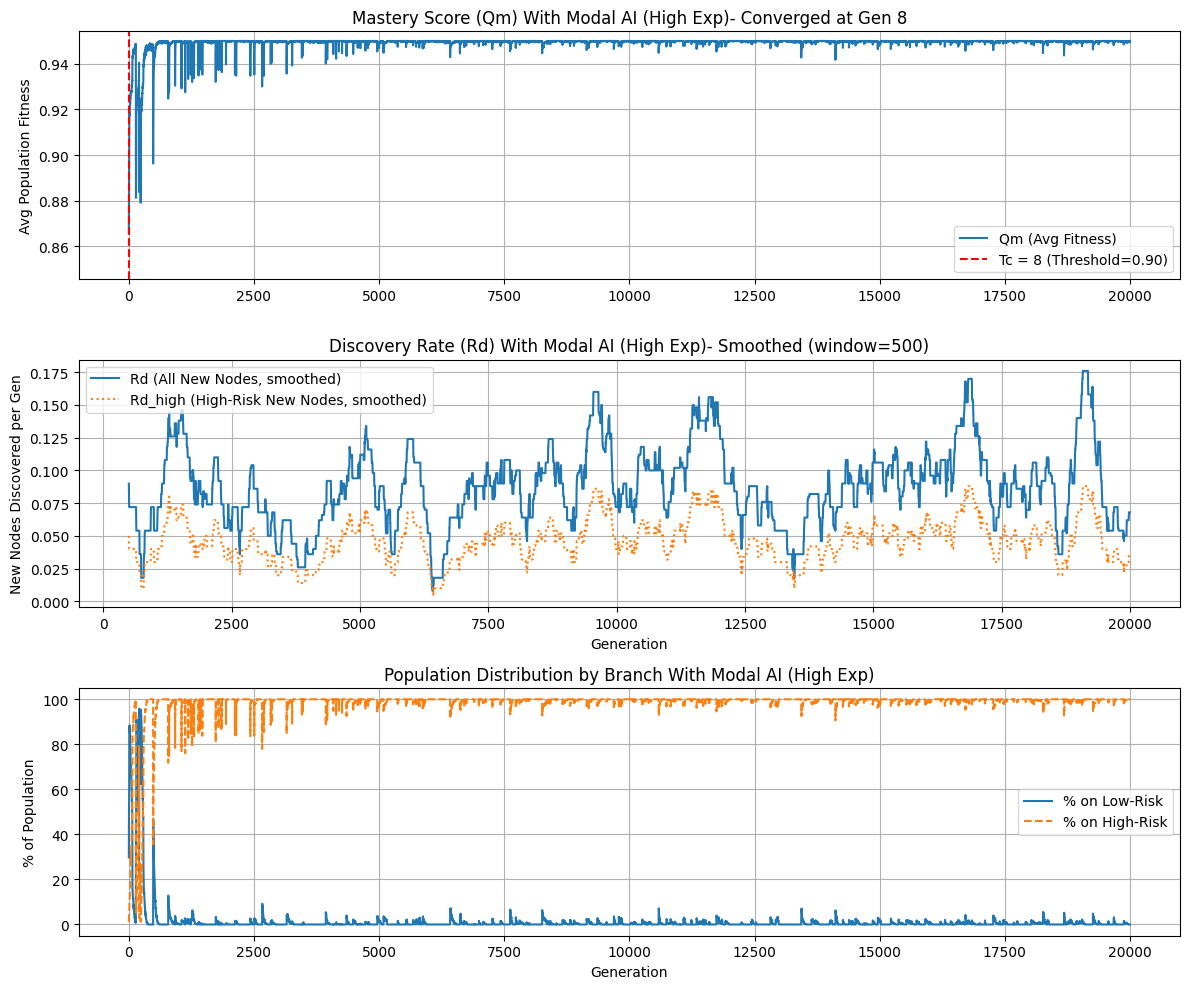


--- Tweaking: Higher c_I (0.10) ---


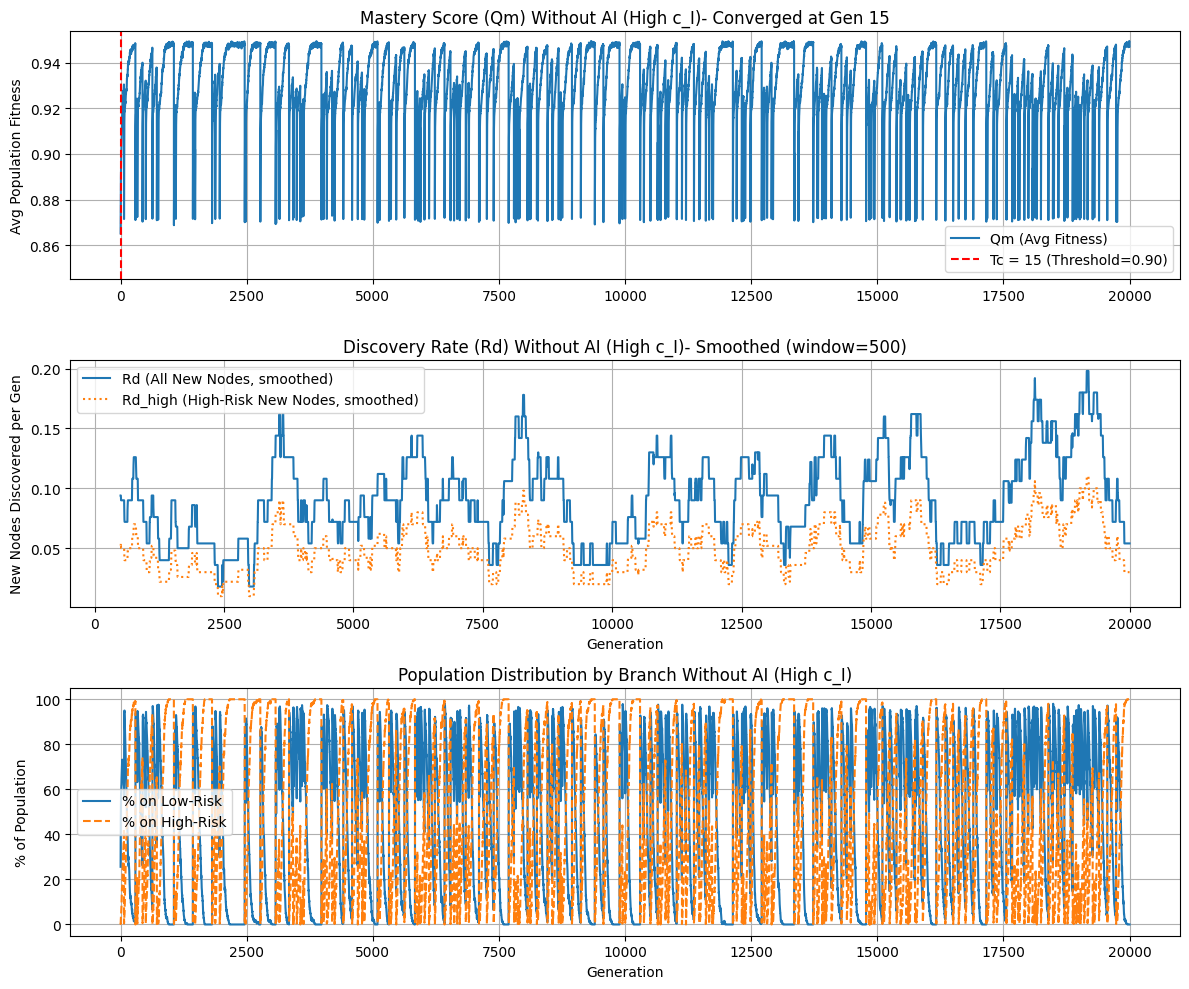

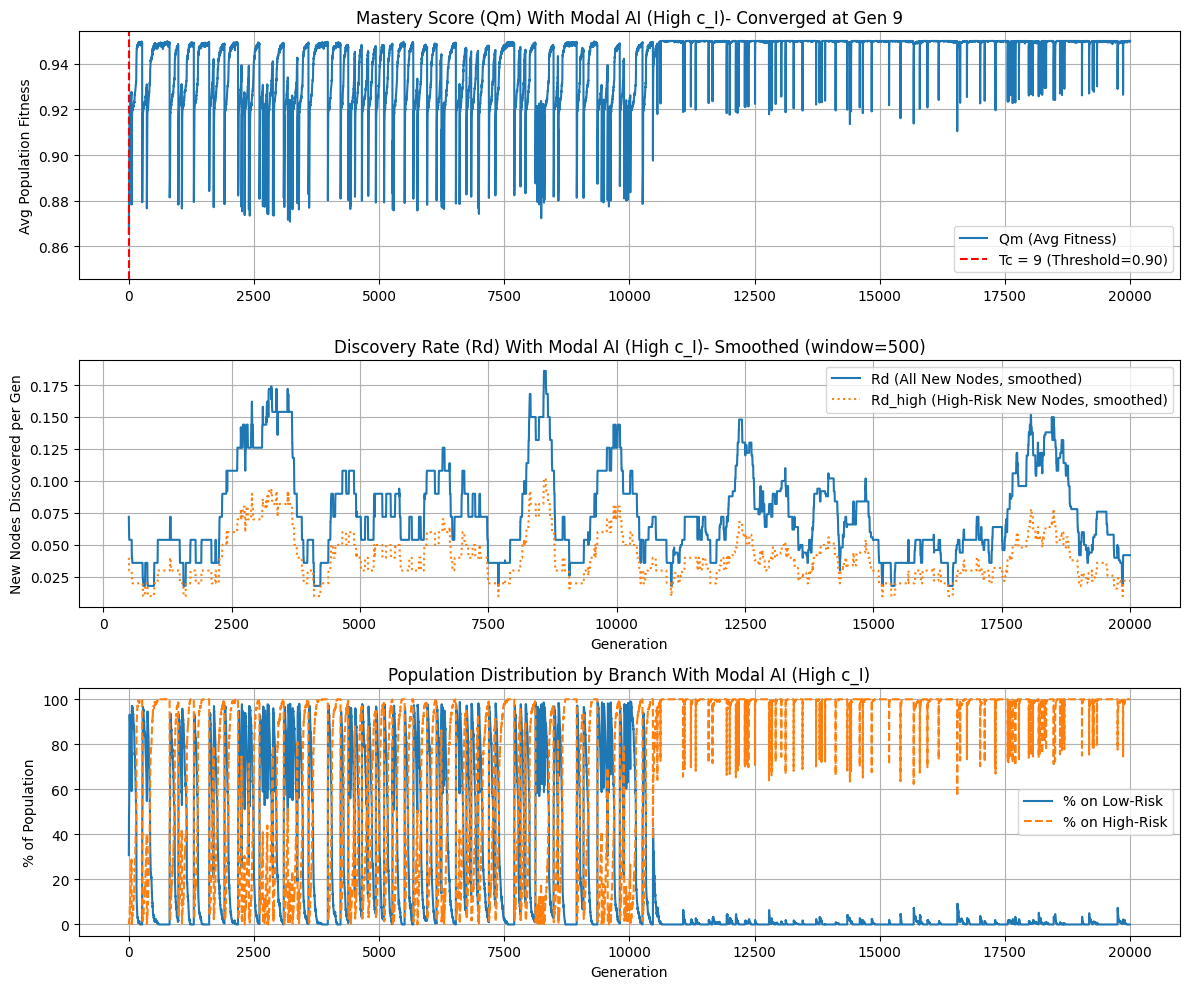

In [16]:
# --- 4. Experiment Runner and Plotting ---

# FIX 4: Add scenario_label argument and update titles
def plot_simulation_results(results, scenario_label=""):
    """Plots the key metrics from a simulation run."""
    gens = range(results['params']['n_generations'])
    Qm = results['Qm']
    Rd = results['Rd']
    Rd_high = results['Rd_high']
    Tc = results['Tc']
    pop_dist = results['pop_dist']
    # FIX 4: Get threshold from results dictionary
    threshold_val = results['params'].get('critical_threshold', 0.90)

    plt.figure(figsize=(12, 10))

    # Plot Mastery Score (Qm)
    plt.subplot(3, 1, 1)
    plt.plot(gens, Qm, label=f'Qm (Avg Fitness)')
    if Tc != -1:
        plt.axvline(Tc, color='r', linestyle='--', label=f'Tc = {Tc} (Threshold={threshold_val:.2f})')
        # FIX 4: Update title
        plt.title(f"Mastery Score (Qm) {scenario_label}- Converged at Gen {Tc}")
    else:
        # FIX 4: Update title
        plt.title(f"Mastery Score (Qm) {scenario_label}- Did Not Converge")
    plt.ylabel("Avg Population Fitness")
    plt.ylim(bottom=min(Qm)-0.02 if Qm else 0.8)
    plt.legend()
    plt.grid(True)


    # Plot Discovery Rate (Rd)
    plt.subplot(3, 1, 2)
    window = 500
    # Ensure Rd and Rd_high have enough elements for convolution
    if len(Rd) >= window:
        Rd_smooth = np.convolve(Rd, np.ones(window)/window, mode='valid')
        Rd_high_smooth = np.convolve(Rd_high, np.ones(window)/window, mode='valid')
        plt.plot(gens[window-1:], Rd_smooth, label='Rd (All New Nodes, smoothed)')
        plt.plot(gens[window-1:], Rd_high_smooth, label='Rd_high (High-Risk New Nodes, smoothed)', linestyle=':')
    else: # Plot raw data if too short for smoothing
        plt.plot(gens, Rd, label='Rd (All New Nodes, raw)')
        plt.plot(gens, Rd_high, label='Rd_high (High-Risk New Nodes, raw)', linestyle=':')
    # FIX 4: Update title
    plt.title(f"Discovery Rate (Rd) {scenario_label}- Smoothed (window={window})")
    plt.ylabel("New Nodes Discovered per Gen")
    plt.xlabel("Generation")
    plt.legend()
    plt.grid(True)

     # Plot Population Distribution
    plt.subplot(3, 1, 3)
    # Check if pop_dist is not empty before processing
    if pop_dist:
        low_risk_pct = [d.get('low_risk', 0) * 100 for d in pop_dist]
        high_risk_pct = [d.get('high_risk', 0) * 100 for d in pop_dist]
        # start_pct = [d.get('start', 0) * 100 for d in pop_dist] # Optional
        plt.plot(gens, low_risk_pct, label='% on Low-Risk')
        plt.plot(gens, high_risk_pct, label='% on High-Risk', linestyle='--')
        # plt.plot(gens, start_pct, label='% at Start', linestyle=':') # Optional
    # FIX 4: Update title
    plt.title(f"Population Distribution by Branch {scenario_label}")
    plt.ylabel("% of Population")
    plt.xlabel("Generation")
    plt.legend()
    plt.grid(True)


    plt.tight_layout()
    plt.show()

# --- Run Parameter Tweaking Experiments ---

# Baseline (already run, assuming results_no_ai and results_with_ai exist)
# print("--- Baseline ---")
# plot_simulation_results(results_no_ai, scenario_label="Without AI (Baseline)")
# plot_simulation_results(results_with_ai, scenario_label="With Modal AI (Baseline)")

# Tweak 1: Lower exploration_prob
print("\n--- Tweaking: Lower exploration_prob (0.005) ---")
params_low_exp = {
    'knowledge_map_dict': knowledge_map, 'N': 500, 'n_generations': 20000,
    'exploration_prob': 0.005, 'alpha': 1.0
}
# Without AI
results_no_ai_low_exp = run_simulation_knowledge_map(**params_low_exp, ai_mode='none')
plot_simulation_results(results_no_ai_low_exp, scenario_label="Without AI (Low Exp)")
# With AI
results_with_ai_low_exp = run_simulation_knowledge_map(**params_low_exp, ai_mode='modal')
plot_simulation_results(results_with_ai_low_exp, scenario_label="With Modal AI (Low Exp)")


# Tweak 2: Higher exploration_prob
print("\n--- Tweaking: Higher exploration_prob (0.02) ---")
params_high_exp = {
    'knowledge_map_dict': knowledge_map, 'N': 500, 'n_generations': 20000,
    'exploration_prob': 0.02, 'alpha': 1.0
}
# Without AI
results_no_ai_high_exp = run_simulation_knowledge_map(**params_high_exp, ai_mode='none')
plot_simulation_results(results_no_ai_high_exp, scenario_label="Without AI (High Exp)")
# With AI
results_with_ai_high_exp = run_simulation_knowledge_map(**params_high_exp, ai_mode='modal')
plot_simulation_results(results_with_ai_high_exp, scenario_label="With Modal AI (High Exp)")

# Tweak 3: Higher c_I
print("\n--- Tweaking: Higher c_I (0.10) ---")
params_high_cI = {
    'knowledge_map_dict': knowledge_map, 'N': 500, 'n_generations': 20000,
    'c_I': 0.10, 'alpha': 1.0
}
# Without AI
results_no_ai_high_cI = run_simulation_knowledge_map(**params_high_cI, ai_mode='none')
plot_simulation_results(results_no_ai_high_cI, scenario_label="Without AI (High c_I)")
# With AI
results_with_ai_high_cI = run_simulation_knowledge_map(**params_high_cI, ai_mode='modal')
plot_simulation_results(results_with_ai_high_cI, scenario_label="With Modal AI (High c_I)")

### Params Tweaking Analysis

1. **Higher c_I (Cost of Individual Learning)** - Without AI(Comparing to our original "Without AI" plot)


*   Mastery Score ($Q_M$): Converges slightly faster ($T_c = 15$ vs. 19). The large oscillations between high fitness (~ 0.95) and lower fitness (~0.88) persist. Making IL more costly doesn't stop the population from eventually finding and exploiting the high-risk branch when recovering from dips.

*   Discovery Rate ($R_D$): The pattern remains similar to the baseline "Without AI" case. Peaks in discovery (both overall and high-risk) occur when the population recovers from fitness dips. $R_{D\_high}$ still tracks $R_D$ reasonably well.

*   Population Distribution: Still shows dramatic oscillations between the Low-Risk and High-Risk branches. The increased cost of IL doesn't prevent the population from exploring and finding the High-Risk branch, especially during recovery periods.

***Interpretation:*** The oscillatory dynamic in the "Without AI" scenario seems fairly robust to increases in the cost of exploration. The population still manages to find the better path eventually.

2. **Lower exploration_prob** - Without AI (Comparing to our original "Without AI" plot)



*   Mastery Score ($Q_M$): Converges faster ($T_c = 11$ vs. 19). The oscillations persist, similar to the baseline.

*   Discovery Rate ($R_D$): The overall discovery rate and the high-risk discovery rate ($R_{D\_high}$) seem lower on average than the baseline. This makes sense – if the chance of discovering the high-risk branch is lower, fewer agents will find it each generation, even during recovery.

*   Population Distribution: Continues to show large oscillations. Making the initial discovery harder doesn't stop the oscillation dynamic once the high-risk branch is eventually found by some agents (who can then be copied via SL).


***Interpretation:*** Lowering the fundamental discovery probability reduces the rate of innovation but doesn't eliminate the oscillatory pattern in the absence of the AI.

3. **Higher exploration_prob** - With Modal AI(Comparing to our original "With Modal AI" plot)



*   Mastery Score ($Q_M$): Converges extremely quickly ($T_c = 8$). Most strikingly, after converging, the fitness becomes very stable near the global optimum (~ 0.95), unlike the baseline "With AI" case which got stuck near the local optimum (~0.92).

*   Discovery Rate ($R_D$): There's an initial burst of high discovery (including high-risk discovery). However, after the population converges onto the high-risk branch, the discovery rate drops significantly and stays low, similar to how it dropped in the baseline "With AI" case (though maybe slightly higher average $R_D$ here).

*   Population Distribution: The population rapidly locks onto the High-Risk branch (orange line near 100%) and stays there with very high stability. This is a major difference from the baseline "With AI" where it locked onto the Low-Risk branch.


***Interpretation:*** This is a key finding! The Modal AI's tendency to lock onto the most common state is highly dependent on how quickly the High-Risk branch is initially discovered.

  *   If exploration_prob is low (baseline), the Low-Risk branch becomes common first, and the AI traps the population there.
  *   If exploration_prob is high, the High-Risk branch is found quickly enough by enough agents to become the "modal" state, and the AI correctly reinforces the globally optimal path.
  *   Crucially: Even when the AI guides the population to the correct global optimum, it still appears to suppress further significant discovery after convergence compared to the oscillating "Without AI" scenarios.



**Overall Takeaways & Next Steps**



1.   Robustness: The core finding that the Modal AI suppresses the long-term Discovery Rate ($R_D$) compared to "Without AI" seems robust, even when the AI correctly identifies the global optimum.

2.   **Sensitivity**: The AI's effectiveness in finding the global vs. local optimum is highly sensitive to the exploration_prob. This suggests that in real-world scenarios, an AI reinforcing the "most popular" idea might only lead to the best outcome if the best idea is discovered very quickly and widely early on.
3.   **Next Steps:** Will move onto Phase 2. Will explore:


      *   If Critical Social Learning can maintain high fitness and allow for continued discovery when the AI is present (especially in the baseline exploration_prob case where the AI normally gets stuck).

      *   How different AI modes ('mean', 'prestige') compare to 'modal', especially their sensitivity to exploration_prob.

      *   How environmental volatility (u) changes the relative benefits of the AI's stabilizing effect versus the "Without AI" oscillatory exploration.



# Phase 2: Experimenting with learning strategies & exploring the impact of AI parameters

### Step 1: Implement Critical Social Learning (CSL)

**Goal:** Modify the agent's learning logic so that if they attempt social learning (from AI or human) and it fails (doesn't result in moving to a better node or discovering a new one), they get a chance to perform Individual Learning (IL) within the same generation. This tests if allowing agents to override unsuccessful social learning can restore innovation.


**Reasoning:** CSL adds a layer of agent rationality. Instead of blindly copying, agents evaluate the outcome. If copying doesn't help (e.g., the AI is stuck on the low-risk plateau, or the copied human isn't advanced), the agent reverts to costly exploration.

In [17]:
# previous Core Simulation Function but modified "Learning Phase"---
def run_simulation_knowledge_map(
    knowledge_map_dict, # Pass the map definition
    N=1000,
    n_generations=50000, # Shorter for initial testing, increase later
    u=0.01, # Environmental change prob
    c_I=0.05, # Cost of IL
    z_I=0.66, # Success rate of IL
    c_S=0.0, # Cost of SL
    # s0, s1 are replaced by V(Kj) from the map
    phi=0.5, # Initial proportion of social learners
    mu=0.005, # Mutation rate
    exploration_prob=0.01, # Prob of Exploratory IL
    alpha=1.0, # Strength of Status-Biased SL (set > 0 to enable)
    ai_mode='modal', # AI learning rule: 'modal', 'mean', 'prestige', or 'none'
    ai_update_cadence=1, # How often AI updates (1 = every generation)
    critical_threshold=0.90, # Example threshold for Tc
    convergence_window=100, # Window for checking Tc stability
    convergence_epsilon=0.0001, # Threshold for Tc stability
    enable_critical_social_learning=False #added this parameter
    ):
    """Runs the simulation on the Knowledge Map."""

    agent_states, is_social_learner, ai_bias, age, discovered_nodes = initialize_population(N, phi)

    # --- Metrics Tracking ---
    history_Qm = [] # Mastery Score
    history_Rd = [] # Discovery Rate (new nodes per gen)
    history_Rd_high = [] # Discovery Rate for High-Risk branch
    history_pop_distribution = [] # Track % of pop on each branch

    Tc = -1 # Convergence time, -1 if not reached
    ai_state = START_NODE # Initial AI knowledge

    # --- Determine minlength for bincount (FIX 1)---
    max_node_id = max(knowledge_map_dict.keys())
    bincount_minlength = max_node_id + 1


    # === Generation Loop ===
    for gen in range(n_generations):

        # --- Environmental Change (Optional Reset) ---
        if np.random.rand() < u:
            # Reset agent states and discoveries (simplest form)
            agent_states.fill(START_NODE)
            discovered_nodes = {START_NODE}
            # Could implement more complex resets later if needed

        # --- Updated Learning Phase ---
        new_agent_states = agent_states.copy()
        new_discoveries_this_gen = 0
        new_discoveries_high_risk = 0

        for i in range(N):
            initial_state = agent_states[i] # Store state before learning
            learned_successfully_socially = False # Flag for CSL

            # --- Determine Learning Strategy ---
            learn_social = is_social_learner[i]

            if learn_social:
                # --- Social Learning Attempt ---
                if np.random.rand() > c_S:
                    teach_from_ai = (np.random.rand() < ai_bias[i]) and (ai_mode != 'none')
                    original_state_before_sl = new_agent_states[i] # Store state before SL attempt

                    if teach_from_ai:
                        # --- AI Learning Attempt ---
                        new_state_attempt = ai_state
                        new_agent_states[i] = new_state_attempt
                        # --- CSL Check: Did AI learning help? ---
                        # Define "successful": moved to a higher fitness node OR discovered a new node
                        if knowledge_map_dict.get(new_state_attempt, {}).get('fitness', 0) > knowledge_map_dict.get(original_state_before_sl, {}).get('fitness', 0) or \
                           new_state_attempt not in discovered_nodes:
                           learned_successfully_socially = True
                        # No explicit penalty here, deskilling is structural

                    else:
                        # --- Human Social Learning Attempt ---
                        # (a) Local SL: Filter peers...
                        # (b) Status-Biased SL...
                        # (Code for selecting teacher_index remains the same)
                        if 'teacher_index' in locals() and teacher_index is not None: # Check if a teacher was found
                            new_state_attempt = agent_states[teacher_index]
                            new_agent_states[i] = new_state_attempt
                            # --- CSL Check: Did Human SL help? ---
                            if knowledge_map_dict.get(new_state_attempt, {}).get('fitness', 0) > knowledge_map_dict.get(original_state_before_sl, {}).get('fitness', 0) or \
                               new_state_attempt not in discovered_nodes:
                               learned_successfully_socially = True
                            # Reset teacher_index for next agent
                            del teacher_index
                        else:
                            # No local peers found for SL
                            learn_social = False # Force fallback to IL

                    # --- If SL attempt DID NOT help AND CSL is enabled, revert state and flag for IL ---
                    if not learned_successfully_socially and enable_critical_social_learning:
                        new_agent_states[i] = original_state_before_sl # Revert state
                        learn_social = False # Flag to now try IL

            # --- Individual Learning (IL) ---
            # This block now runs if the agent is an individual learner OR
            # if they are a social learner who failed SL and CSL is enabled.
            if not learn_social:
                if np.random.rand() > c_I:
                    if np.random.rand() < z_I:
                        if np.random.rand() < exploration_prob:
                            new_state = HIGH_RISK_START_NODE
                            new_agent_states[i] = new_state
                        else:
                            current_node = initial_state # Use state before any learning this gen
                            if current_node in knowledge_map_dict:
                                next_node = knowledge_map_dict[current_node]['next_node']
                                if next_node is not None:
                                    new_state = next_node
                                    new_agent_states[i] = new_state
                                else:
                                    new_state = current_node
                            else:
                                new_state = initial_state
                    else: # IL failed intrinsically
                         new_state = initial_state
                else: # Failed cost check for IL
                    new_state = initial_state


            # --- Check for New Discovery ---
            final_new_state = new_agent_states[i]
            if final_new_state in knowledge_map_dict and final_new_state not in discovered_nodes:
                 new_discoveries_this_gen += 1
                 discovered_nodes.add(final_new_state)
                 if knowledge_map_dict[final_new_state]['branch'] == 'high_risk':
                     new_discoveries_high_risk += 1


        agent_states = new_agent_states # Update all agent states

        # --- Survival Phase ---
        # Get current fitness values for *all* agents, ensuring state exists in map
        agent_fitness_values = np.array([knowledge_map_dict.get(state, {'fitness': 0.0})['fitness'] for state in agent_states])
        survival_roll = np.random.rand(N)
        survival_mask = survival_roll < agent_fitness_values

        # Store the fitness values *before* applying the mask for Qm calculation
        current_pop_fitness_values = agent_fitness_values

        agent_states = agent_states[survival_mask]
        is_social_learner = is_social_learner[survival_mask]
        ai_bias = ai_bias[survival_mask]
        age = age[survival_mask]
        age += 1 # Increment age of survivors

        # --- Reproduction Phase ---
        current_pop_size = len(agent_states)
        n_offspring = N - current_pop_size

        if n_offspring > 0:
            if current_pop_size == 0: # Handle extinction case
                 agent_states, is_social_learner, ai_bias, age, discovered_nodes = initialize_population(N, phi)
            else:
                parent_indices = np.random.choice(current_pop_size, size=n_offspring, replace=True)

                offspring_states = agent_states[parent_indices]
                offspring_social = is_social_learner[parent_indices]
                offspring_bias = ai_bias[parent_indices]

                mutation_mask_social = np.random.rand(n_offspring) < mu
                offspring_social[mutation_mask_social] = ~offspring_social[mutation_mask_social]

                mutation_mask_bias = np.random.rand(n_offspring) < mu
                offspring_bias[mutation_mask_bias] += np.random.normal(0, 0.1, size=np.sum(mutation_mask_bias))

                agent_states = np.concatenate((agent_states, offspring_states))
                is_social_learner = np.concatenate((is_social_learner, offspring_social))
                ai_bias = np.concatenate((ai_bias, offspring_bias))
                age = np.concatenate((age, np.ones(n_offspring, dtype=np.int64)))

        # --- AI Update Phase ---
        if ai_mode != 'none' and gen % ai_update_cadence == 0:
            if len(agent_states) > 0:
                if ai_mode == 'modal':
                    # FIX 2: More robust mode extraction
                    mode_result = stats.mode(agent_states)
                    ai_state = mode_result.mode[0] if isinstance(mode_result.mode, np.ndarray) else mode_result.mode
                elif ai_mode == 'mean':
                     mean_pop_fitness = np.mean([knowledge_map_dict.get(s, {'fitness': 0.0})['fitness'] for s in agent_states])
                     node_fitnesses = np.array([v['fitness'] for v in knowledge_map_dict.values()])
                     closest_node_idx = np.abs(node_fitnesses - mean_pop_fitness).argmin()
                     ai_state = list(knowledge_map_dict.keys())[closest_node_idx]
                elif ai_mode == 'prestige':
                     fitness_vals = [knowledge_map_dict.get(s, {'fitness': 0.0})['fitness'] for s in agent_states]
                     if fitness_vals: # Check if list is not empty
                         best_agent_idx = np.argmax(fitness_vals)
                         ai_state = agent_states[best_agent_idx]
                     else: # Default if no agents have fitness (shouldn't happen if pop > 0)
                        ai_state = START_NODE

            else:
                ai_state = START_NODE


        # --- Record Metrics for this Generation ---
        current_Qm = np.mean(current_pop_fitness_values) if N > 0 else 0
        history_Qm.append(current_Qm)
        history_Rd.append(new_discoveries_this_gen)
        history_Rd_high.append(new_discoveries_high_risk)

        # Calculate population distribution
        # FIX 1: Ensure counts array is large enough
        counts = np.bincount(agent_states, minlength=bincount_minlength)

        start_nodes = [n for n, props in knowledge_map_dict.items() if props['branch'] == 'start']
        low_risk_nodes = [n for n, props in knowledge_map_dict.items() if props['branch'] == 'low_risk']
        high_risk_nodes = [n for n, props in knowledge_map_dict.items() if props['branch'] == 'high_risk']

        # Ensure indices are within bounds of counts array before summing
        start_nodes_valid = [n for n in start_nodes if n < len(counts)]
        low_risk_nodes_valid = [n for n in low_risk_nodes if n < len(counts)]
        high_risk_nodes_valid = [n for n in high_risk_nodes if n < len(counts)]


        dist = {
            'start': np.sum(counts[start_nodes_valid]) if start_nodes_valid else 0,
            'low_risk': np.sum(counts[low_risk_nodes_valid]) if low_risk_nodes_valid else 0,
            'high_risk': np.sum(counts[high_risk_nodes_valid]) if high_risk_nodes_valid else 0,
        }
        history_pop_distribution.append({k: v/N for k, v in dist.items()})


        # --- Check for Convergence (Tc) ---
        if Tc == -1:
            if current_Qm >= critical_threshold:
                 Tc = gen + 1


    # === End of Simulation ===
    return {
        'Qm': history_Qm,
        'Rd': history_Rd,
        'Rd_high': history_Rd_high,
        'Tc': Tc,
        'pop_dist': history_pop_distribution,
        'params': { # Keep track of parameters used
             'N':N, 'n_generations':n_generations, 'u':u, 'c_I':c_I, 'z_I':z_I, 'c_S':c_S,
             'phi':phi, 'mu':mu, 'exploration_prob':exploration_prob, 'alpha':alpha, 'ai_mode':ai_mode,
             'ai_update_cadence':ai_update_cadence,
             'enable_critical_social_learning': enable_critical_social_learning
        }
    }

**Explanation of Changes:**

1. Added enable_critical_social_learning parameter (defaults to False).

2. Inside the social learning block, we store the agent's state *before* the SL attempt.

3. We add a flag learned_successfully_socially. This is set to True only if the SL attempt results in moving to a node with strictly higher fitness OR discovering a brand new node.

4. If learned_successfully_socially is False and enable_critical_social_learning is True, we revert the agent's state back to what it was before the SL attempt and set learn_social = False.

5. The IL block is now triggered if learn_social is False (either initially, or because SL failed under CSL).


Running Simulation WITH Modal AI + CSL...


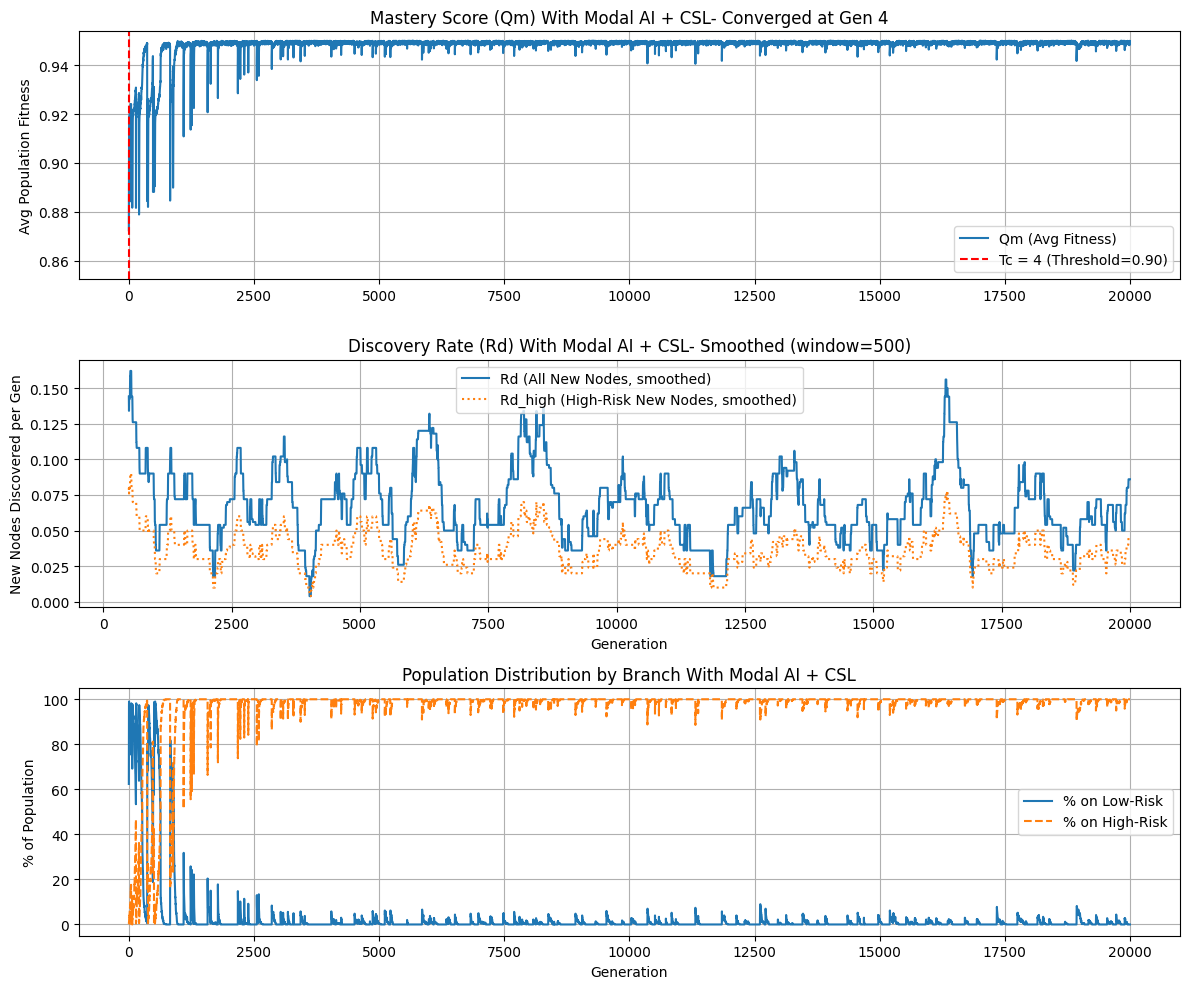

In [18]:
print("\nRunning Simulation WITH Modal AI + CSL...")
params_with_ai_csl = {
    'knowledge_map_dict': knowledge_map,
    'N': 500,
    'n_generations': 20000,
    'ai_mode': 'modal',
    'alpha': 1.0,
    'enable_critical_social_learning': True # <<< Enable CSL
}
results_with_ai_csl = run_simulation_knowledge_map(**params_with_ai_csl)
plot_simulation_results(results_with_ai_csl, scenario_label="With Modal AI + CSL")

#### **Critical Social Learning (CSL) Analysis**

(Comparing Modal AI + CSL vs. Baseline Modal AI)

**Finding:** Adding CSL dramatically improves the outcome when using a Modal AI. The population converges even faster ( Tc=4 ) and consistently locks onto the High-Risk (global optimum) branch, maintaining a high and stable  QM  near 0.95.

**Mechanism:** CSL allows agents to abandon the AI when it offers no improvement (i.e., when it's stuck reinforcing the Low-Risk plateau). This forces agents back into Individual Learning, increasing the chance they'll eventually perform Exploratory IL, discover the High-Risk branch, and pull the rest of the population (including the AI) towards it via social learning.

**Trade-off:** While CSL helps find the correct optimum, it doesn't prevent the suppression of discovery after convergence. Like the 'Prestige' AI, once the population (and AI) settles on the High-Risk plateau, both  RD  and  RD_high  drop significantly.

**Conclusion:** CSL is an effective agent-level strategy to overcome the 'Modal AI trap' and achieve optimal Mastery, but it doesn't inherently sustain long-term Discovery better than other converging strategies.

### Step 2: Implement Varying AI Update Cadence

**Goal:** Control how often the AI updates its knowledge based on the population mean/mode. Test if a less frequently updated AI allows more exploration.

**Reasoning:** If the AI updates constantly, it quickly locks onto the early Low-Risk majority. If it updates less often, its knowledge might lag, potentially giving the population more time to explore the High-Risk branch before the AI starts strongly reinforcing the Low-Risk one.


Running Simulation WITH Modal AI (Update Cadence = 1)...


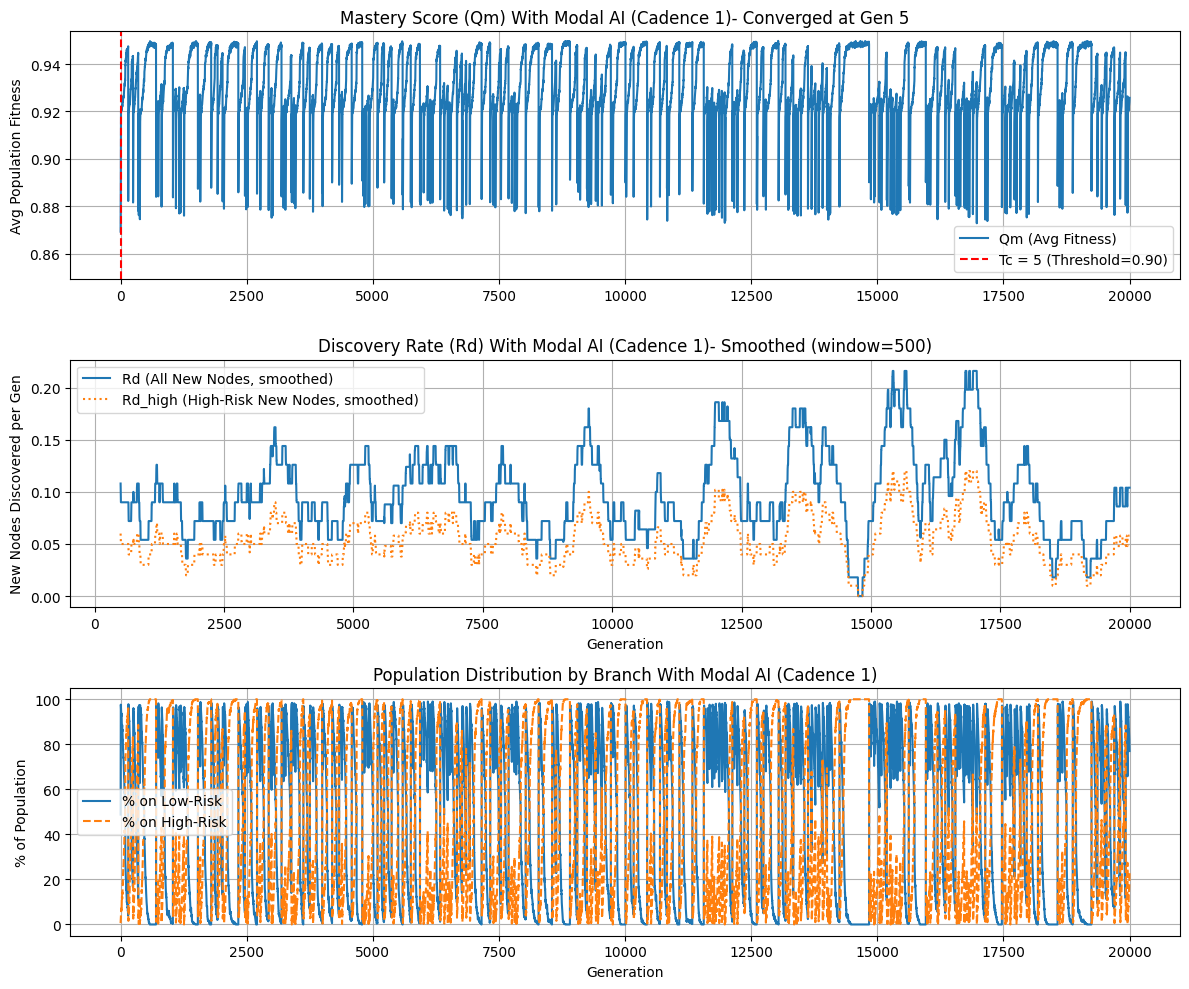


Running Simulation WITH Modal AI (Update Cadence = 10)...


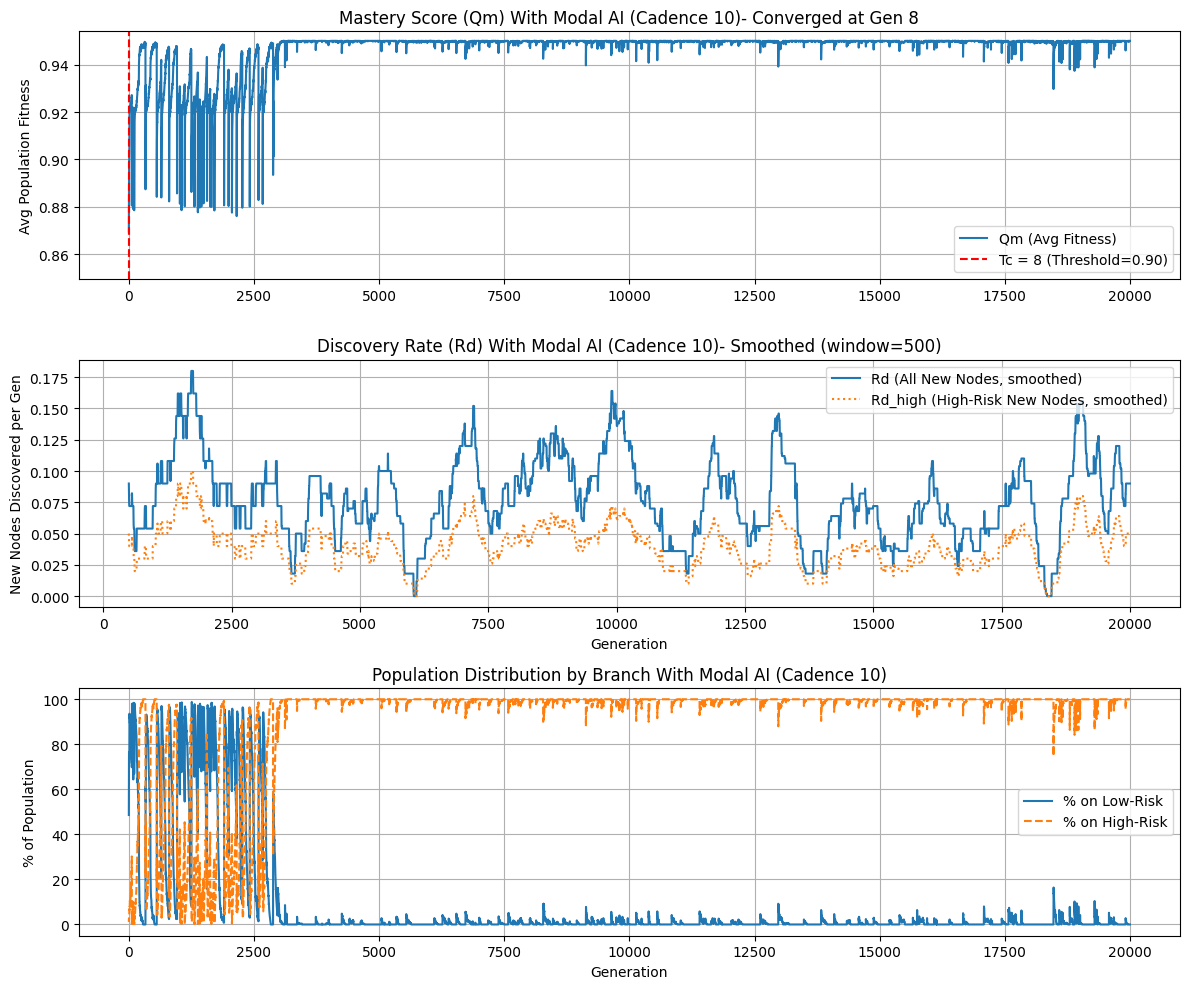


Running Simulation WITH Modal AI (Update Cadence = 50)...


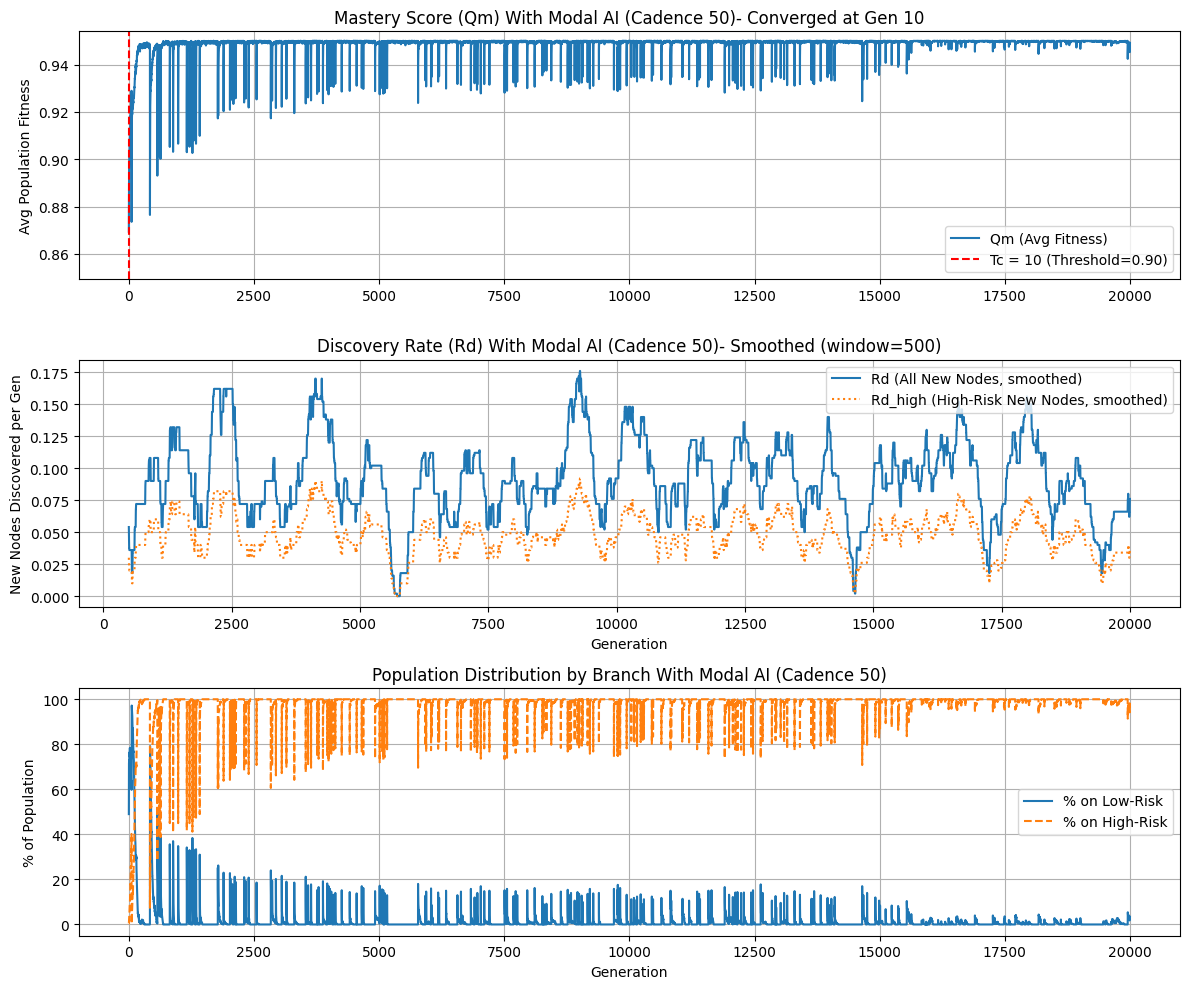


Running Simulation WITH Modal AI (Update Cadence = 100)...


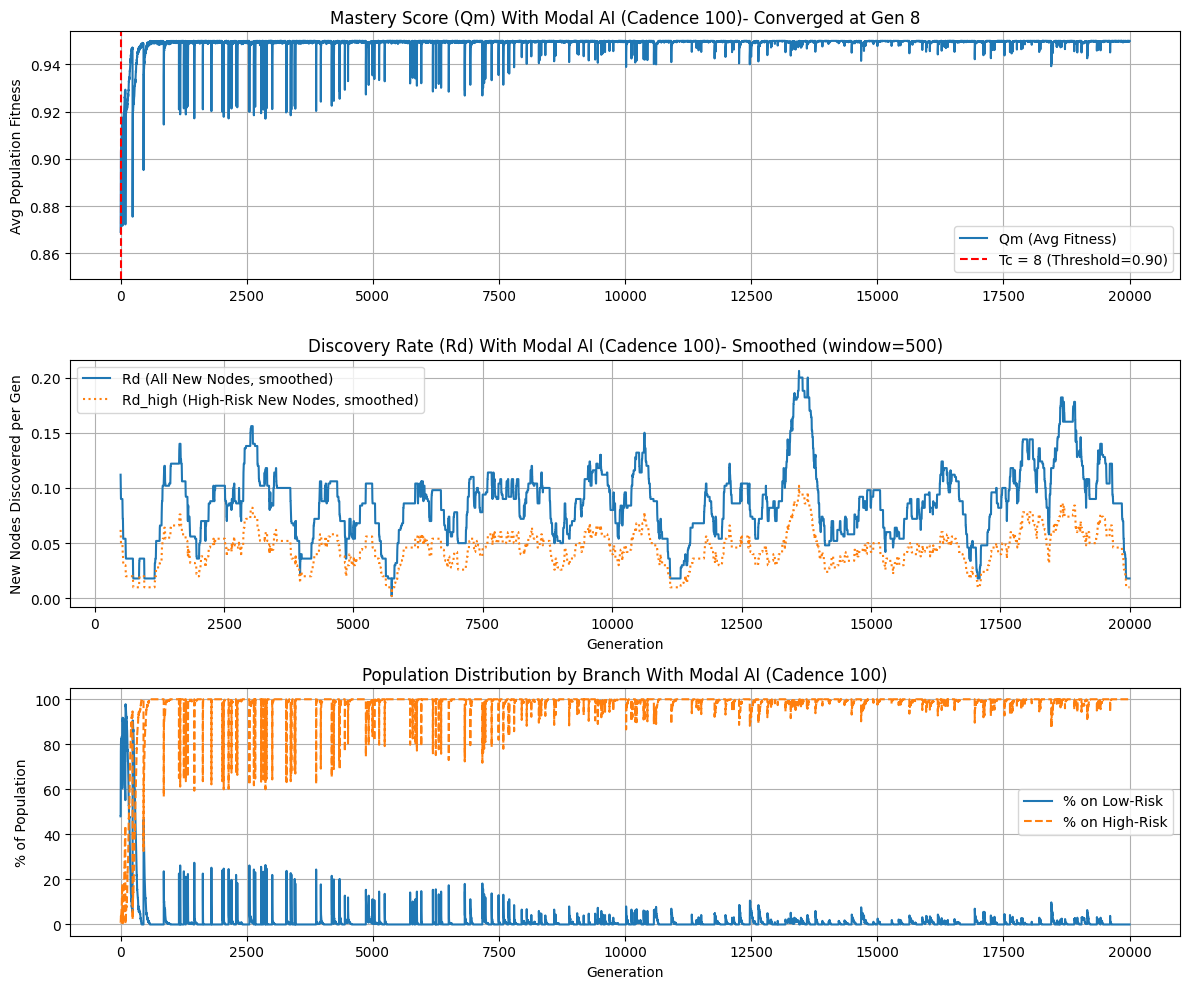

In [19]:
cadences_to_test = [1, 10, 50, 100] # Update every gen, every 10, every 50, every 100

results_by_cadence = {}

for cadence in cadences_to_test:
    print(f"\nRunning Simulation WITH Modal AI (Update Cadence = {cadence})...")
    params_cadence = {
        'knowledge_map_dict': knowledge_map,
        'N': 500,
        'n_generations': 20000,
        'ai_mode': 'modal',
        'alpha': 1.0,
        'enable_critical_social_learning': False, # Keep CSL off for this specific test
        'ai_update_cadence': cadence # <<< Vary the cadence
    }
    results_by_cadence[cadence] = run_simulation_knowledge_map(**params_cadence)
    plot_simulation_results(results_by_cadence[cadence], scenario_label=f"With Modal AI (Cadence {cadence})")

# You can then compare the plots or final metrics across different cadences.

#### **AI Update Cadence Analysis**

(Comparing Modal AI with Cadence 1, 10, 50, 100)

**Finding:** Reducing the AI's update frequency (increasing cadence) makes the system behave more like the "Without AI" scenario.


*   Cadence 1 (updating every generation) locks onto the Low-Risk branch.

*   Cadences 10, 50, and 100 show increasing oscillations between Low-Risk and High-Risk branches, mirroring the "Without AI" plot (image_fef28c.jpg). $Q_M$ becomes less stable, but $R_D$ and especially $R_{D\_high}$ show higher average rates and more frequent peaks during the recovery phases of oscillations.


**Mechanism:** A less frequently updated AI exerts weaker conformist pressure. Its knowledge lags behind the population's current state, giving agents more time and opportunity to explore (or follow explorers) onto the High-Risk branch before the AI "notices" and starts reinforcing the potentially sub-optimal majority state again.

**Conclusion:** Slower AI updates can mitigate the innovation suppression caused by a Modal AI, allowing for more discovery, but at the cost of reduced $Q_M$ stability. This highlights a direct trade-off controllable at the AI system level.

### Step 3: Implement Different AI Learning Modes

**Goal:** Test how the AI's strategy for learning from the population affects the outcome. Compare 'modal' (most common), 'mean' (closest to average fitness), and 'prestige' (highest fitness agent).

**Reasoning:**


*   'Modal' reinforces conformity.
*   'Mean' might be less extreme but still lean towards the easier path if the average fitness is higher there initially.
*   'Prestige' might be better at identifying the High-Risk branch if even one agent reaches a high fitness there, potentially pulling the population towards the global optimum.


Code Implementation:

The logic for ai_mode = 'modal', 'mean', and 'prestige' is already included in the Phase 1 code within the # --- AI Update Phase ---. I would just run experiments specifying these modes.


Running Simulation WITH Modal AI...


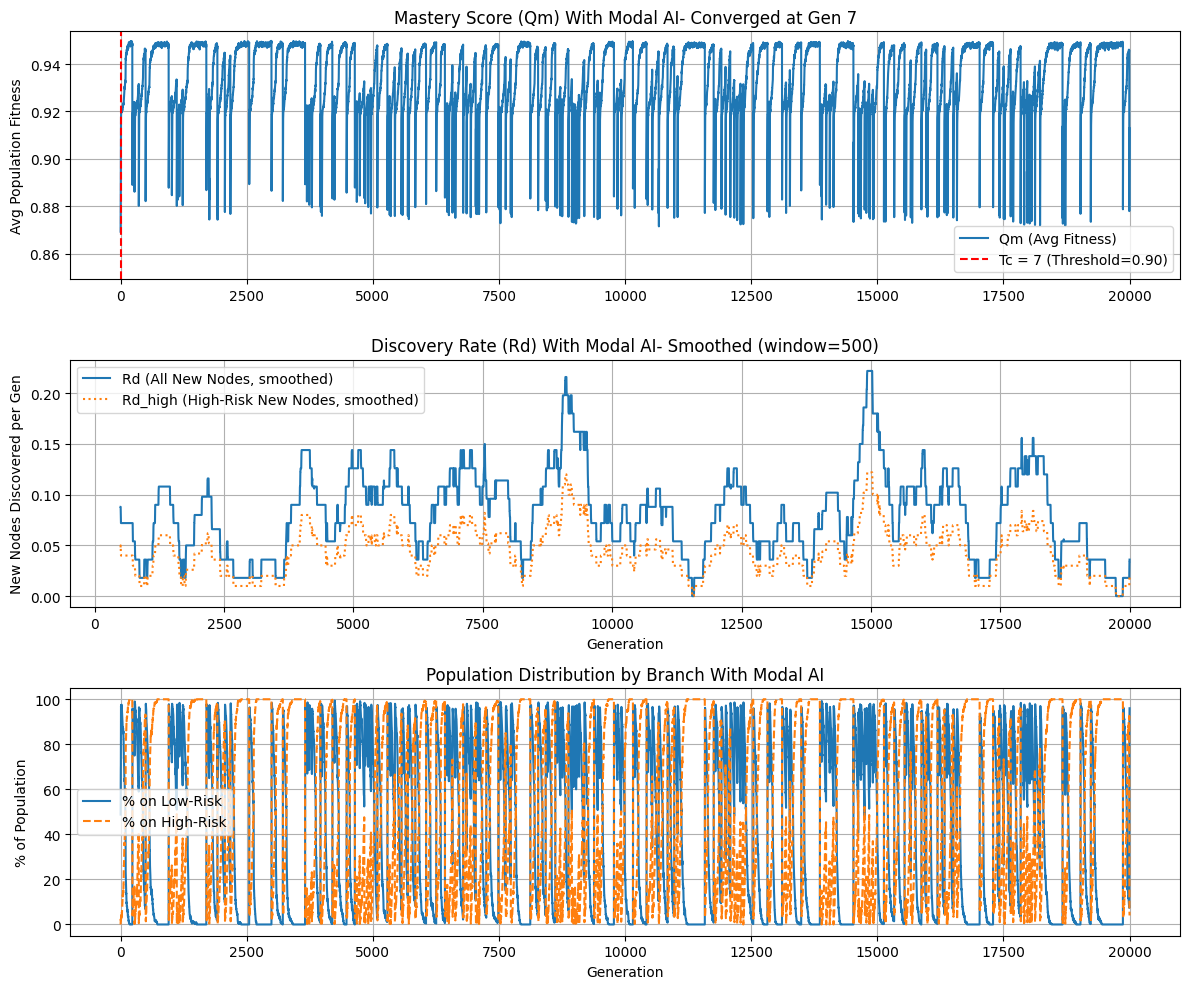


Running Simulation WITH Mean AI...


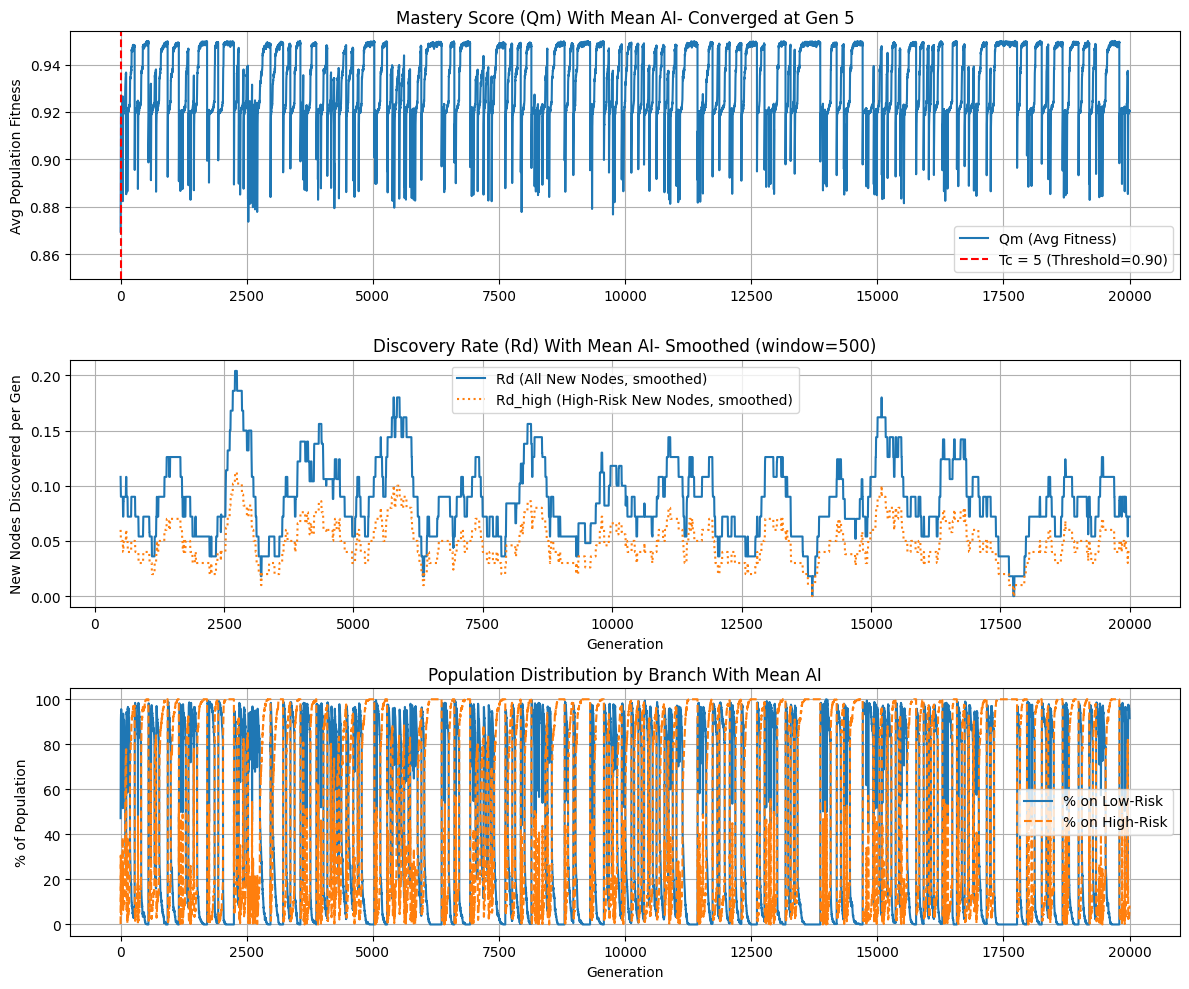


Running Simulation WITH Prestige AI...


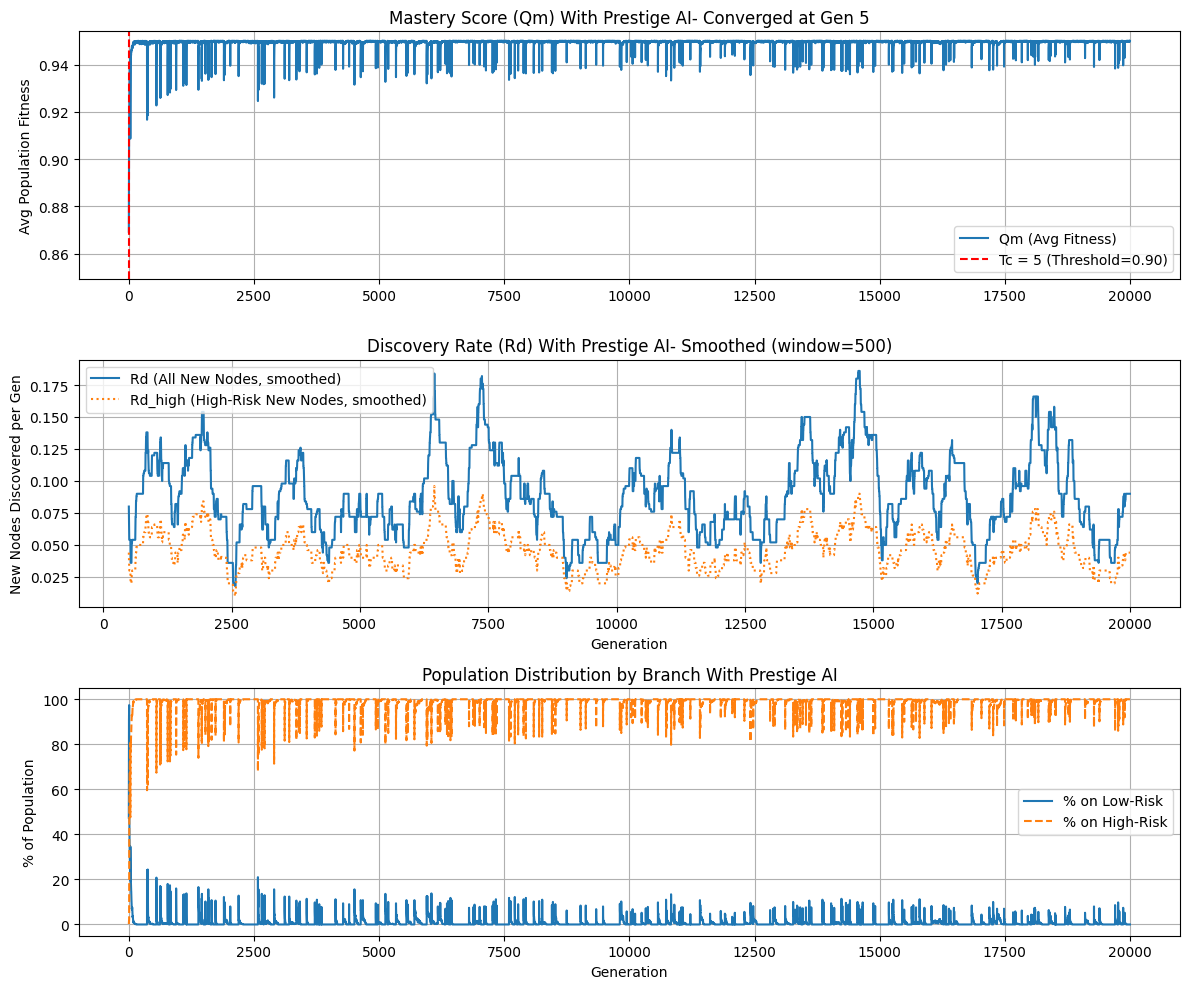

In [20]:
ai_modes_to_test = ['modal', 'mean', 'prestige']
results_by_ai_mode = {}

for mode in ai_modes_to_test:
    print(f"\nRunning Simulation WITH {mode.capitalize()} AI...")
    params_ai_mode = {
        'knowledge_map_dict': knowledge_map,
        'N': 500,
        'n_generations': 20000,
        'ai_mode': mode, # <<< Vary the AI mode
        'alpha': 1.0,
        'enable_critical_social_learning': False # Keep CSL off
    }
    results_by_ai_mode[mode] = run_simulation_knowledge_map(**params_ai_mode)
    plot_simulation_results(results_by_ai_mode[mode], scenario_label=f"With {mode.capitalize()} AI")

# Compare the plots for 'modal', 'mean', and 'prestige' AI.

#### **Different AI Modes Analysis**

**Finding**: The AI's learning strategy has a massive impact:



*   **Modal AI:** Converges quickly ($T_c=7$) but gets stuck on the Low-Risk branch, suppressing $R_{D\_high}$.

*   **Mean AI:** Converges quickly ($T_c=5$) but results in large oscillations similar to the "Without AI" case. $Q_M$ is unstable, but $R_D$ and $R_{D\_high}$ remain relatively high and variable.

*   **Prestige AI:** Converges quickly ($T_c=5$) and consistently locks onto the High-Risk branch, achieving high, stable $Q_M$. However, like CSL, it suppresses $R_D$/$R_{D\_high}$ after convergence.


**Mechanism:**


*   Modal follows the crowd (often the easy path).

*   Mean seems ineffective; averaging fitness might not provide a strong enough signal, letting natural oscillations dominate.

*   Prestige follows the best agent, allowing it to quickly identify and reinforce the globally optimal High-Risk branch once even a few agents make significant progress there.


**Conclusion:** 'Prestige' AI is the most effective for achieving high, stable Mastery of the best available knowledge. However, 'Mean' AI (and slow-updating Modal AI, or No AI) is better for sustaining Discovery, albeit with less stability. 'Modal' AI (with fast updates) seems the worst overall in this map configuration, maximizing speed but often converging to the wrong peak and suppressing innovation.

### Step 4: Running Systematic Parameter Sweeps (Varying u and c_I)

**Goal:** Systematically explore how environmental volatility (u) and the cost of exploration (c_I) interact with the presence and type of AI.

**Reasoning:** As discussed in the feedback, the "best" strategy (AI vs. No AI, exploration vs. exploitation) likely depends heavily on these core environmental and cost parameters.

**Code Implementation:** Setting up loops to iterate through different values of u and c_I, running simulations for relevant conditions (e.g., No AI, Modal AI, Prestige AI) at each combination. Store key summary metrics (like average $Q_M$ in the last N generations, total $R_{D\_high}$) for comparison.

Running: u=0.005, c_I=0.03, AI Mode=none
Running: u=0.005, c_I=0.03, AI Mode=modal
Running: u=0.005, c_I=0.03, AI Mode=prestige
Running: u=0.005, c_I=0.05, AI Mode=none
Running: u=0.005, c_I=0.05, AI Mode=modal
Running: u=0.005, c_I=0.05, AI Mode=prestige
Running: u=0.005, c_I=0.1, AI Mode=none
Running: u=0.005, c_I=0.1, AI Mode=modal
Running: u=0.005, c_I=0.1, AI Mode=prestige
Running: u=0.005, c_I=0.2, AI Mode=none
Running: u=0.005, c_I=0.2, AI Mode=modal
Running: u=0.005, c_I=0.2, AI Mode=prestige
Running: u=0.01, c_I=0.03, AI Mode=none
Running: u=0.01, c_I=0.03, AI Mode=modal
Running: u=0.01, c_I=0.03, AI Mode=prestige
Running: u=0.01, c_I=0.05, AI Mode=none
Running: u=0.01, c_I=0.05, AI Mode=modal
Running: u=0.01, c_I=0.05, AI Mode=prestige
Running: u=0.01, c_I=0.1, AI Mode=none
Running: u=0.01, c_I=0.1, AI Mode=modal
Running: u=0.01, c_I=0.1, AI Mode=prestige
Running: u=0.01, c_I=0.2, AI Mode=none
Running: u=0.01, c_I=0.2, AI Mode=modal
Running: u=0.01, c_I=0.2, AI Mode=prestige


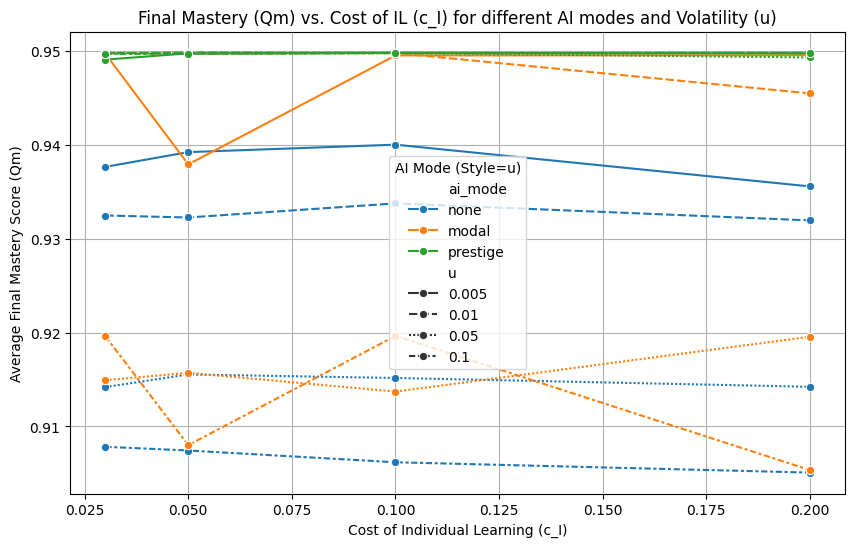

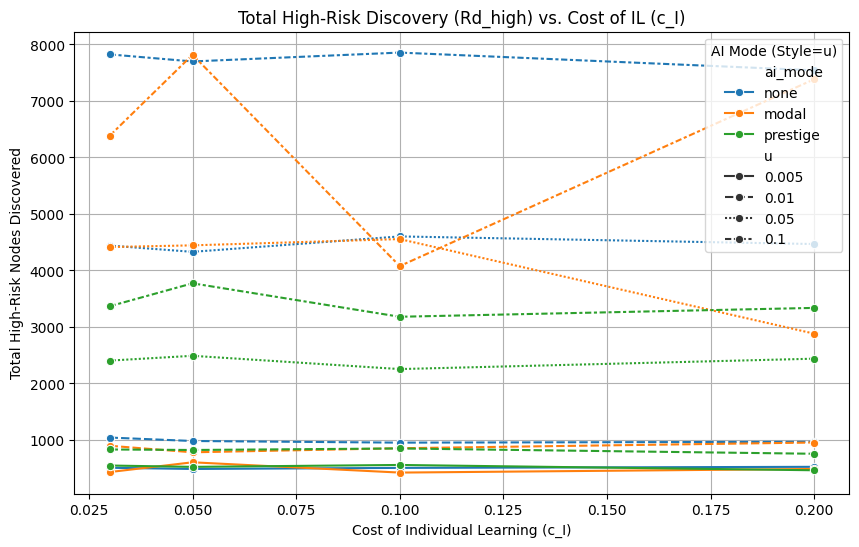

In [21]:
import pandas as pd
# --- Parameter Ranges ---
u_values = [0.005, 0.01, 0.05, 0.1]
c_I_values = [0.03, 0.05, 0.10, 0.20]
conditions = ['none', 'modal', 'prestige'] # ai_mode conditions to test

# --- Data Storage ---
sweep_results = []

# --- Run the Sweep ---
for u_val in u_values:
    for c_I_val in c_I_values:
        for ai_m in conditions:
            print(f"Running: u={u_val}, c_I={c_I_val}, AI Mode={ai_m}")
            params_sweep = {
                'knowledge_map_dict': knowledge_map,
                'N': 500,           # Use smaller N/gens for faster sweeps initially
                'n_generations': 20000, # Adjust as needed
                'u': u_val,         # Vary u
                'c_I': c_I_val,       # Vary c_I
                'ai_mode': ai_m,      # Vary AI mode
                'alpha': 1.0,
                'enable_critical_social_learning': False # Keep consistent for this sweep
            }
            results = run_simulation_knowledge_map(**params_sweep)

            # --- Store Summary Metrics ---
            # Example: Average Qm over last 20% of simulation
            final_Qm_avg = np.mean(results['Qm'][-int(params_sweep['n_generations']*0.2):])
            total_Rd_high = np.sum(results['Rd_high'])
            convergence_time = results['Tc']

            sweep_results.append({
                'u': u_val,
                'c_I': c_I_val,
                'ai_mode': ai_m,
                'final_Qm_avg': final_Qm_avg,
                'total_Rd_high': total_Rd_high,
                'Tc': convergence_time
            })

# --- Analyze Sweep Results ---
results_df = pd.DataFrame(sweep_results)
print("\n--- Sweep Results Summary ---")
print(results_df)

# You can now analyze results_df to see how u and c_I affect metrics under different AI conditions
# Example: Plot final Qm vs c_I for different u values, comparing AI modes
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='c_I', y='final_Qm_avg', hue='ai_mode', style='u', marker='o')
plt.title('Final Mastery (Qm) vs. Cost of IL (c_I) for different AI modes and Volatility (u)')
plt.xlabel('Cost of Individual Learning (c_I)')
plt.ylabel('Average Final Mastery Score (Qm)')
plt.grid(True)
plt.legend(title='AI Mode (Style=u)')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='c_I', y='total_Rd_high', hue='ai_mode', style='u', marker='o')
plt.title('Total High-Risk Discovery (Rd_high) vs. Cost of IL (c_I)')
plt.xlabel('Cost of Individual Learning (c_I)')
plt.ylabel('Total High-Risk Nodes Discovered')
plt.grid(True)
plt.legend(title='AI Mode (Style=u)')
plt.show()

#### **Parameter Sweeps (u and c_I) Analysis**


*   **Finding 1 (Final $Q_M$):**

'Prestige' AI consistently achieves the highest final $Q_M$ (~0.95), proving robust across different costs (c_I) and volatilities (u).

'None' (No AI) performance degrades as exploration cost (c_I) increases and as volatility (u) increases. High volatility punishes the slow recovery needed after environmental resets.

'Modal' AI is very sensitive. It matches 'Prestige' at low c_I but performs poorly (getting stuck low) when c_I is high, especially under high volatility (u=0.1).

*   **Finding 2 (Total $R_{D\_high}$):**

'None' (No AI) generally yields the highest total High-Risk discovery, especially in more volatile environments (u=0.05, 0.1). Volatility forces re-exploration, leading to more cumulative discovery over time if exploration cost (c_I) isn't prohibitive. $R_{D\_high}$ decreases for 'None' as c_I rises.

'Modal' AI sometimes matches 'None' for $R_{D\_high}$ (when u is high and c_I low), but often results in significantly less discovery, particularly when c_I is high.

'Prestige' AI consistently results in lower total High-Risk discovery than 'None', especially at higher u. It finds the best path quickly but then stops significant exploration.

*   ***Conclusion:*** The parameter sweeps confirm the fundamental trade-off.

For maximizing stable, peak performance ($Q_M$), 'Prestige' AI is superior, especially when exploration is costly or the world is volatile.

For maximizing cumulative innovation ($R_{D\_high}$), having no AI appears best, particularly in volatile environments where forced re-exploration is beneficial (assuming exploration cost isn't too high).

'Modal' AI is unreliable; its outcome depends heavily on specific parameter combinations.


### Step 5: Overall Conclusions & Relation to Hypothesis

Our results strongly validate our primary hypothesis: the presence of a cheap social learning AI (especially a 'Modal' one) significantly increases Mastery Score ($Q_M$) stabilization speed ($T_c$) but often at the cost of a dramatically decreased long-run Discovery Rate ($R_D$), particularly for the innovative High-Risk knowledge.

**Key Nuances Revealed:**


1.   **AI Strategy Matters:** The type of AI dramatically alters the trade-off. 'Prestige' optimizes for performance, 'Modal' optimizes for conformity (which can be sub-optimal), and 'Mean' has little stabilizing effect.

2.   *Agent Strategy Matters:* Critical Social Learning allows agents to overcome the 'Modal' AI trap to reach the global optimum, improving $Q_M$ significantly, but still leads to reduced exploration post-convergence.

2.   **Context is Crucial (Parameters):** The relative benefit of AI vs. No AI depends heavily on:


      *   Exploration Cost (c_I): High costs favor AI for performance but hinder innovation without AI.

      *   Environmental Volatility (u): High volatility favors Prestige AI for stability ($Q_M$) but favors No AI for maximizing cumulative discovery ($R_{D\_high}$).

      *   AI Update Cadence: Slower updates reduce the AI's impact, allowing more exploration.
      

Our Knowledge Map model successfully captures complexities missed by the original binary state model, demonstrating that optimizing for short-term mastery/convergence via AI can indeed stifle the exploration needed for long-term innovation. 💡 The "best" approach depends critically on the specific goals (peak performance vs. continuous discovery) and the environmental context.